In [382]:
# import modules
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from sklearn.metrics import confusion_matrix, log_loss, f1_score

import random
from math import floor
from scipy.stats import mode, scoreatpercentile

print("Seaborn version : ", sns.__version__)
sns.set()
#sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_theme(style="ticks", palette="pastel")



# upload data
train = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/train.csv',index_col=0)
test = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/test.csv',index_col=0)
submit = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/sample_submission.csv')

Seaborn version :  0.11.1


In [383]:
# defs
def show_4digits(x) : 
    return str(x)[:3]

In [384]:
# outliers
train.drop((train[train['child_num']>=6]).index, inplace = True)

In [385]:
for df in [train, test] : 
    # no information
    df.drop('FLAG_MOBIL',axis = 1, inplace = True)

    # negative to positive
    df['DAYS_BIRTH'] = -df['DAYS_BIRTH']
    df['DAYS_EMPLOYED'] = -df['DAYS_EMPLOYED']
    df['begin_month'] = -df['begin_month']

    # handling the missing values
    ## occyp_type == NaN
    df['occyp_type'] = df.occyp_type.fillna('missing')
    df.loc[(df.DAYS_EMPLOYED == -365243)&(df.occyp_type.isna()), 'occyp_type'] = 'in_occyp'
    ## DAYS_EMPLOYED == 365243
    df['DAYS_EMPLOYED'][df['DAYS_EMPLOYED'] == -365243] = 0

In [386]:
for df in [train, test] : 
    # personal_id
    df['personal_id']= \
    df['gender']+\
    df['car']+\
    df['income_total'].apply(lambda x: str(int(x)).zfill(7))+\
    df['edu_type'].apply(show_4digits)+\
    df['family_type'].apply(show_4digits)+\
    df['house_type'].apply(show_4digits)+\
    df['DAYS_BIRTH'].apply(lambda x: str(x).zfill(5))+\
    df['DAYS_EMPLOYED'].apply(lambda x: str(x).zfill(5))+\
    df['occyp_type'].apply(show_4digits)

    # 재산, 연락처에 관한 정보들을 묶어서 분류
    df['group_property'] = df['car'].astype(str)   + df['reality'].astype(str)
    df['group_contacts'] = df['phone'].astype(str) + df['work_phone'].astype(str) + df['email'].astype(str)
    df['group_whoare_u'] = df['gender'].astype(str)+ df['family_type'].astype(str)

In [387]:
for df in [train, test] : 
    # 현재 하고 있는 일을 시작하게 된 나이(날짜) = 일을 하지 않았던 기간 
    df['DAYS_nowork'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']

    # 가족 수와 관련된 변수
    df['adult_num'] = df['family_size'] - df['child_num']
    df.loc[df.child_num >= 5, 'child_num'] = 5
    df.loc[df.child_num >= 5, 'family_size'] = df.loc[df.child_num >= 5, 'child_num'] + df.loc[df.child_num >= 5, 'adult_num']

    # 소득과 관련된 변수와 조합
    df['income_per_child'] = df['income_total']/ df['child_num']  #소득을 아이 수로 나눠 각 아이에게 할당 될 수 있는 금액을 계산 
    df['income_per_family']= df['income_total']/ df['family_size']#소득을 가족 수로 나눠 각 인원에게 할당 될 수 있는 금액을 계산
    df['income_per_age']   = df['income_total']/ df['DAYS_BIRTH'] #소득을 나이로 나눠 나이 대비 얼마나 버는지에 대한 지표 생성

    # 로그 변환(income_total)
    df['income_total_log'] = np.log(df['income_total']+1)

    # 날짜표기 변환(begin_month) : 4로 나누어 계절로 분할
    df['begin_season'] = df['begin_month'].apply(lambda x: floor(x/4))

    # 날짜표기 변환(DAYS_EMPLOYED) : 개월로 binning
    df['mm_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/30.4375))

    # 날쨔 표기 변환(DAYS_EMPLOYED): 연차로 binning
    df['yy_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/365.25))



In [388]:
personal_info = train.drop(['credit', 'begin_month'], axis = 1).drop_duplicates(subset='personal_id', keep='first', inplace=False, ignore_index=True)

F, F_birth_labels = pd.qcut(personal_info.DAYS_BIRTH[personal_info.gender == 'F'], q = 20, retbins=True)
M, M_birth_labels = pd.qcut(personal_info.DAYS_BIRTH[personal_info.gender == 'M'], q = 20, retbins=True)
F_birth_labels.put(0, F_birth_labels[0]-.001)
M_birth_labels.put(0, M_birth_labels[0]-.001)


personal_info['age_F_bins'] = F
personal_info['n_F_age'] = personal_info.groupby('age_F_bins').gender.count()
personal_info['age_M_bins'] = M
personal_info['n_M_age'] = personal_info.groupby('age_M_bins').gender.count()

personal_info['income_mean_F_age']  = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = F_birth_labels), 'gender']).income_total.transform(np.mean)
personal_info['income_mean_M_age']  = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = M_birth_labels), 'gender']).income_total.transform(np.mean)
personal_info['income_std_F_age']   = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = F_birth_labels), 'gender']).income_total.transform(np.std)
personal_info['income_std_M_age']   = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = M_birth_labels), 'gender']).income_total.transform(np.std)

personal_info['employed_mean_F_age']= personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = F_birth_labels), 'gender']).DAYS_EMPLOYED.transform(np.mean)
personal_info['employed_mean_M_age']= personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = M_birth_labels), 'gender']).DAYS_EMPLOYED.transform(np.mean)
personal_info['employed_std_F_age'] = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = F_birth_labels), 'gender']).DAYS_EMPLOYED.transform(np.std)
personal_info['employed_std_M_age'] = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = M_birth_labels), 'gender']).DAYS_EMPLOYED.transform(np.std)

F_age_info = personal_info.groupby('age_F_bins')[['income_mean_F_age', 'income_std_F_age', 'employed_mean_F_age', 'employed_std_F_age', 'n_F_age']].apply(np.mean)
M_age_info = personal_info.groupby('age_M_bins')[['income_mean_M_age', 'income_std_M_age', 'employed_mean_M_age', 'employed_std_M_age', 'n_M_age']].apply(np.mean)



In [392]:
pre_ = test.DAYS_BIRTH.iloc[6031]
test.DAYS_BIRTH.iloc[6031] = 7757

for df in [train, test]:
    df['age_F_bins'] = pd.cut(df.DAYS_BIRTH, bins = F_birth_labels)
    df['age_M_bins'] = pd.cut(df.DAYS_BIRTH, bins = M_birth_labels)

#예외 발생(test)
test.DAYS_BIRTH.iloc[6031] = pre_

train = pd.merge(train, F_age_info, how = 'left', on = 'age_F_bins')
train = pd.merge(train, M_age_info, how = 'left', on = 'age_M_bins')
test = pd.merge(test, F_age_info, how = 'left', on = 'age_F_bins')
test = pd.merge(test, M_age_info, how = 'left', on = 'age_M_bins')

for df in [train, test]:
    df['ability_income_per_age_by_gen'] = 0
    df['ability_income_per_age_by_gen'][df.gender == 'F'] = ((df['income_total'] - df['income_mean_F_age'])/(df['income_std_F_age']/df['n_F_age'].apply(np.sqrt)))[df.gender == 'F']
    df['ability_income_per_age_by_gen'][df.gender == 'M'] = ((df['income_total'] - df['income_mean_M_age'])/(df['income_std_M_age']/df['n_M_age'].apply(np.sqrt)))[df.gender == 'M']
    df['ability_emp_per_age_by_gen'] = 0
    df['ability_emp_per_age_by_gen'][df.gender == 'F'] = ((df['DAYS_EMPLOYED'] - df['employed_mean_F_age'])/(df['employed_std_F_age']/df['n_F_age'].apply(np.sqrt)))[df.gender == 'F']
    df['ability_emp_per_age_by_gen'][df.gender == 'M'] = ((df['DAYS_EMPLOYED'] - df['employed_mean_M_age'])/(df['employed_std_M_age']/df['n_M_age'].apply(np.sqrt)))[df.gender == 'M']
    

In [394]:
drop_list = [#'income_total', 
             'age_F_bins', 'age_M_bins', 
             'income_mean_F_age', 'income_std_F_age', 'employed_mean_F_age', 'employed_std_F_age', 'n_F_age',
             'income_mean_M_age', 'income_std_M_age', 'employed_mean_M_age', 'employed_std_M_age', 'n_M_age', 
            ]

for df in [train, test]:
    df.drop(drop_list, axis = 1, inplace = True)

In [231]:
one_child_fee = (personal_info.income_total/personal_info.family_size)[(personal_info.DAYS_BIRTH > 33*365) & (personal_info.DAYS_BIRTH < 37*365) & (personal_info.child_num == 1)].mean()



68241.43079584774

In [70]:
# 부모의 학력이 올라갈 수록 자녀에 투자하는 금액이 많을것이다.
# 버는 만큼? => 소득 수준
# 아이의 수 만큼?
# 부모의 나이 만큼?

# 부모의 학력에 대한 가중치 * 아이의 수 가중치 * 부모의 나이 가중치* 부모의 소득 가중치
# merge형태(모수가 있다.)
#personal_info['weight_edu'] = personal_info.groupby('edu_type').income_total.transform(np.mean)
# 함수 형태(모수는 없음.) => 데이터에 직접 적용
#personal_info['weight_chd'] = personal_info['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
#personal_info['weight_age'] = personal_info['']

In [395]:
df_weight_edu = personal_info.groupby('edu_type').income_total.apply(np.mean)#.reset_index()
df_weight_edu.name = 'weight_edu'
df_weight_edu = df_weight_edu.reset_index()

In [260]:
from scipy.stats import norm

In [141]:
d_age_std = 11#[8, 20, 2]
d_age_mu  = 34#[30, 40]
weight_c = 1 #[0.1~ 2, 0.1]

train_money = pd.merge(train, df_weight_edu, how = 'left', on = 'edu_type') # 'weight_edu'
train_money['weight_chd'] = train_money['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
train_money['weight_age'] = train_money['DAYS_BIRTH'].transform(lambda x: norm(d_age_mu, scale = d_age_std).pdf((x/365.25))/norm(d_age_mu, scale = d_age_std).pdf(d_age_mu))
train_money['child_fee_total'] = one_child_fee*train_money['weight_edu']*train_money['weight_chd']*train_money['weight_age']*train_money['income_total_log']

In [424]:
# car fee

loc_par_car = personal_info.income_total.median()
loc_max_car = personal_info.income_total.max()

def car_weight(x, loc_par_car):
    _max = personal_info.income_total.max()
    _med = loc_par_car
    if x < _med : 
        return 1
    else:
        return 1+(x-_med)/(_max-_med)*5



15750.0

In [ ]:
train_money['car_fees_total'] = train_money*income_total.median()*0.1*train_money.car*train_money.income_total.apply(car_weight)

In [154]:

d_age_std = trial.suggest_float("d_age_std", 8, 20, 0.5)
d_age_mu = trial.suggest_int("d_age_mu", 29, 40, 1)
weight_c = trial.suggest_float("weight_c", 0.1, 2)
weight_b = trial.suggest_float("weight_b", 0.1, 2)

train_money['weight_chd'] = train_money['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
train_money['weight_age'] = train_money['DAYS_BIRTH'].transform(lambda x: norm(d_age_mu, scale = d_age_std).pdf((x/365.25))/norm(d_age_mu, scale = d_age_std).pdf(d_age_mu))
train_money['child_fee_total'] = one_child_fee*train_money['weight_edu']*train_money['weight_chd']*train_money['weight_age']*train_money['income_total_log']

train_money.drop(['weight_edu', 'weight_chd', 'weight_age'], axis = 1, inplace = True)
numerical_feats = train_money.dtypes[train_money.dtypes != "object"].index.tolist()
categorical_feats = train_money.dtypes[train_money.dtypes == "object"].index.tolist()
target = 'credit'
X_money = train_money.drop(target, axis=1)
y_money = train_money[target]

n_fold = 5
n_class = 3

Number of Numerical features:  20
Number of Categorical features:  12


In [425]:
personal_info.income_total.median()

157500.0

In [169]:
n_fold = 5
n_class = 3


def objective(trial):
            
    d_age_std = trial.suggest_float("d_age_std", 5, 8)
    d_age_mu = trial.suggest_float("d_age_mu", 34, 36)
    weight_c = trial.suggest_float("weight_c", 1.3, 1.7)
    weight_b = trial.suggest_float("weight_b", 0.1, 2)
    loc_par_car = trial.suggest_int("loc_par_car", 127500.0, 187500.0)

    train_money = pd.merge(train, df_weight_edu, how = 'left', on = 'edu_type') # 'weight_edu'
    train_money['weight_chd'] = train_money['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
    train_money['weight_age'] = train_money['DAYS_BIRTH'].transform(lambda x: norm(d_age_mu, scale = d_age_std).pdf((x/365.25))/norm(d_age_mu, scale = d_age_std).pdf(d_age_mu))
    train_money['child_fee_total'] = one_child_fee*train_money['weight_edu']*train_money['weight_chd']*train_money['weight_age']
    train_money['car_fees_total'] = train_money*income_total.median()*0.1*train_money.car*train_money.income_total.apply(car_weight)
    train_money['save_income'] = train_money['income_total'] - weight_c*train_money['child_fee_total'] - weight_b*train_money['car_fees_total']
    train_money.drop(['weight_edu', 'weight_chd', 'weight_age', 'child_fee_total', 'car_fees_total'], axis = 1, inplace = True)
    
    numerical_feats = train_money.dtypes[train_money.dtypes != "object"].index.tolist()
    categorical_feats = train_money.dtypes[train_money.dtypes == "object"].index.tolist()
    
    target = 'credit'
    X_money = train_money.drop(target, axis=1)
    y_money = train_money[target]

    cat_pred = np.zeros((X_money.shape[0], n_class))
    cat_cols = categorical_feats
    
    skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    folds=[]
    for train_idx, valid_idx in skfold.split(X_money, y_money):
            folds.append((train_idx, valid_idx))


    # 5Fold-CV (StratifiedKFold)
    for fold in range(len(folds)):
        print(f'\n----------------- Fold {fold+1} -----------------\n')
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X_money.iloc[train_idx], X_money.iloc[valid_idx], y_money.iloc[train_idx], y_money.iloc[valid_idx]
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
        valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

        model_cat = CatBoostClassifier(max_depth=8, random_seed=42,
                                       learning_rate=0.1, 
                                       bootstrap_type ='Bernoulli',
                                       used_ram_limit ="8gb",
                                      )
        model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)

        cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
        print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

    print(f'\tLog Loss: {log_loss(y_money, cat_pred):.6f}')
    return log_loss(y_money, cat_pred)

In [170]:
money_weight_study = optuna.create_study(direction="minimize")
money_weight_study.optimize(objective, n_trials=50, timeout=6000)

[I 2021-06-19 01:15:14,367] A new study created in memory with name: no-name-b1926b5b-8cd5-4ea9-bd50-fd4dad8e0c70



----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 39.9ms	remaining: 39.9s
100:	learn: 0.6965679	test: 0.6762688	best: 0.6762577 (99)	total: 4.45s	remaining: 39.6s
200:	learn: 0.6592234	test: 0.6722383	best: 0.6722383 (200)	total: 9.63s	remaining: 38.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6722383382
bestIteration = 200

Shrink model to first 201 iterations.
CV Log Loss Score: 0.672238

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 16.5ms	remaining: 16.5s
100:	learn: 0.6958682	test: 0.6701718	best: 0.6701137 (95)	total: 4.63s	remaining: 41.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6692108255
bestIteration = 128

Shrink model to first 129 iterations.
CV Log Loss Score: 0.669211

----------------- Fold 3 -----------------

0:	learn: 1.0435302	test: 1.0422985	best: 1.0422985 (0)	total: 14.1ms	remaining: 14s
100:	l

[I 2021-06-19 01:18:06,038] Trial 0 finished with value: 0.6661477723491269 and parameters: {'d_age_std': 5.950122812042307, 'd_age_mu': 35.956173637016676, 'weight_c': 1.3196720031335099}. Best is trial 0 with value: 0.6661477723491269.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6676290814
bestIteration = 221

Shrink model to first 222 iterations.
CV Log Loss Score: 0.667629
	Log Loss: 0.666148

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 39.4ms	remaining: 39.4s
100:	learn: 0.6953981	test: 0.6754841	best: 0.6754490 (97)	total: 4.31s	remaining: 38.4s
200:	learn: 0.6583420	test: 0.6724517	best: 0.6724391 (199)	total: 9.19s	remaining: 36.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.672409137
bestIteration = 209

Shrink model to first 210 iterations.
CV Log Loss Score: 0.672409

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 16.3ms	remaining: 16.3s
100:	learn: 0.6955103	test: 0.6694663	best: 0.6693596 (99)	total: 4.31s	remaining: 38.3s
200:	learn: 0.6587844	test: 0.6670658	best: 0.6670658 (200)	total: 9.59s	remaining: 38.1s
Stopped by overfitting dete

[I 2021-06-19 01:21:07,581] Trial 1 finished with value: 0.6657895663420009 and parameters: {'d_age_std': 7.057878322999889, 'd_age_mu': 34.22553440414151, 'weight_c': 1.630356086695732}. Best is trial 1 with value: 0.6657895663420009.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6699215797
bestIteration = 274

Shrink model to first 275 iterations.
CV Log Loss Score: 0.669922
	Log Loss: 0.665790

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 38.2ms	remaining: 38.2s
100:	learn: 0.6924838	test: 0.6760770	best: 0.6760613 (99)	total: 4.21s	remaining: 37.4s
200:	learn: 0.6594727	test: 0.6740870	best: 0.6738725 (184)	total: 9.12s	remaining: 36.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6738725449
bestIteration = 184

Shrink model to first 185 iterations.
CV Log Loss Score: 0.673873

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 18.7ms	remaining: 18.7s
100:	learn: 0.6948949	test: 0.6703208	best: 0.6702149 (93)	total: 4.38s	remaining: 39s
200:	learn: 0.6580236	test: 0.6679484	best: 0.6679484 (200)	total: 9.52s	remaining: 37.8s
Stopped by overfitting detec

[I 2021-06-19 01:23:57,287] Trial 2 finished with value: 0.6663718268173783 and parameters: {'d_age_std': 5.131016787692825, 'd_age_mu': 35.387005207864554, 'weight_c': 1.679275496743279}. Best is trial 1 with value: 0.6657895663420009.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6701306317
bestIteration = 155

Shrink model to first 156 iterations.
CV Log Loss Score: 0.670131
	Log Loss: 0.666372

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 38.9ms	remaining: 38.9s
100:	learn: 0.6960510	test: 0.6756213	best: 0.6756213 (100)	total: 4.08s	remaining: 36.3s
200:	learn: 0.6608732	test: 0.6735045	best: 0.6734675 (198)	total: 9s	remaining: 35.8s
300:	learn: 0.6249596	test: 0.6726155	best: 0.6724980 (277)	total: 14.4s	remaining: 33.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6724980119
bestIteration = 277

Shrink model to first 278 iterations.
CV Log Loss Score: 0.672498

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14.4ms	remaining: 14.4s
100:	learn: 0.6935658	test: 0.6691490	best: 0.6689595 (99)	total: 4.35s	remaining: 38.7s
200:	learn: 0.6596116	test: 

[I 2021-06-19 01:27:01,251] Trial 3 finished with value: 0.666277703554455 and parameters: {'d_age_std': 6.8467203403137304, 'd_age_mu': 35.341965166905034, 'weight_c': 1.3006389323154963}. Best is trial 1 with value: 0.6657895663420009.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6684569414
bestIteration = 229

Shrink model to first 230 iterations.
CV Log Loss Score: 0.668457
	Log Loss: 0.666278

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 37.3ms	remaining: 37.2s
100:	learn: 0.6965854	test: 0.6761561	best: 0.6760350 (98)	total: 4.16s	remaining: 37s
200:	learn: 0.6597471	test: 0.6723091	best: 0.6723091 (200)	total: 9.16s	remaining: 36.4s
300:	learn: 0.6219571	test: 0.6736907	best: 0.6720266 (263)	total: 14.4s	remaining: 33.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6720266156
bestIteration = 263

Shrink model to first 264 iterations.
CV Log Loss Score: 0.672027

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.7ms	remaining: 15.7s
100:	learn: 0.6976504	test: 0.6697703	best: 0.6697070 (99)	total: 4.27s	remaining: 38s
Stopped by overfitting detecto

[I 2021-06-19 01:30:01,441] Trial 4 finished with value: 0.665654179236444 and parameters: {'d_age_std': 6.991088708324565, 'd_age_mu': 35.19678767354427, 'weight_c': 1.5389722104051518}. Best is trial 4 with value: 0.665654179236444.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6699440293
bestIteration = 207

Shrink model to first 208 iterations.
CV Log Loss Score: 0.669944
	Log Loss: 0.665654

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 38.5ms	remaining: 38.4s
100:	learn: 0.6955362	test: 0.6758696	best: 0.6758696 (100)	total: 4.33s	remaining: 38.5s
200:	learn: 0.6593935	test: 0.6736342	best: 0.6735398 (179)	total: 9.27s	remaining: 36.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6725745173
bestIteration = 244

Shrink model to first 245 iterations.
CV Log Loss Score: 0.672575

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14.5ms	remaining: 14.5s
100:	learn: 0.6959329	test: 0.6690073	best: 0.6689875 (99)	total: 4.19s	remaining: 37.3s
200:	learn: 0.6599358	test: 0.6667200	best: 0.6664935 (195)	total: 9.3s	remaining: 37s
Stopped by overfitting detec

[I 2021-06-19 01:32:55,348] Trial 5 finished with value: 0.6660530161953037 and parameters: {'d_age_std': 6.048797025055214, 'd_age_mu': 34.51202507399894, 'weight_c': 1.3685588107371351}. Best is trial 4 with value: 0.665654179236444.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6691193749
bestIteration = 177

Shrink model to first 178 iterations.
CV Log Loss Score: 0.669119
	Log Loss: 0.666053

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 39.2ms	remaining: 39.2s
100:	learn: 0.6965467	test: 0.6758522	best: 0.6758522 (100)	total: 4.15s	remaining: 36.9s
200:	learn: 0.6601634	test: 0.6738405	best: 0.6736851 (159)	total: 9.24s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6729144949
bestIteration = 218

Shrink model to first 219 iterations.
CV Log Loss Score: 0.672914

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14.8ms	remaining: 14.8s
100:	learn: 0.6965545	test: 0.6708438	best: 0.6707914 (96)	total: 4.63s	remaining: 41.2s
200:	learn: 0.6600724	test: 0.6684498	best: 0.6681562 (191)	total: 10s	remaining: 39.9s
300:	learn: 0.6241659	test:

[I 2021-06-19 01:36:13,937] Trial 6 finished with value: 0.6656250944988579 and parameters: {'d_age_std': 7.405384269706854, 'd_age_mu': 34.401852853640676, 'weight_c': 1.3724160504667682}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6688104275
bestIteration = 226

Shrink model to first 227 iterations.
CV Log Loss Score: 0.668810
	Log Loss: 0.665625

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 36.4ms	remaining: 36.3s
100:	learn: 0.6956342	test: 0.6752286	best: 0.6752286 (100)	total: 4.41s	remaining: 39.2s
200:	learn: 0.6612508	test: 0.6726017	best: 0.6726017 (200)	total: 9.34s	remaining: 37.1s
300:	learn: 0.6240094	test: 0.6728027	best: 0.6721678 (256)	total: 14.8s	remaining: 34.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6721678012
bestIteration = 256

Shrink model to first 257 iterations.
CV Log Loss Score: 0.672168

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14.6ms	remaining: 14.6s
100:	learn: 0.6969600	test: 0.6698120	best: 0.6698120 (100)	total: 4.25s	remaining: 37.8s
200:	learn: 0.6604737	te

[I 2021-06-19 01:39:08,110] Trial 7 finished with value: 0.6659473330709419 and parameters: {'d_age_std': 6.341383167552242, 'd_age_mu': 34.68331430503136, 'weight_c': 1.5807226043825977}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.668564878
bestIteration = 217

Shrink model to first 218 iterations.
CV Log Loss Score: 0.668565
	Log Loss: 0.665947

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 38ms	remaining: 38s
100:	learn: 0.6961683	test: 0.6758086	best: 0.6758086 (100)	total: 3.97s	remaining: 35.3s
200:	learn: 0.6612386	test: 0.6715534	best: 0.6713024 (173)	total: 8.81s	remaining: 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6710873196
bestIteration = 217

Shrink model to first 218 iterations.
CV Log Loss Score: 0.671087

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14.3ms	remaining: 14.3s
100:	learn: 0.6954014	test: 0.6695575	best: 0.6694894 (97)	total: 4.15s	remaining: 37s
200:	learn: 0.6589229	test: 0.6667795	best: 0.6666795 (178)	total: 9.24s	remaining: 36.7s
Stopped by overfitting detector  (

[I 2021-06-19 01:41:50,384] Trial 8 finished with value: 0.665803097766054 and parameters: {'d_age_std': 7.489950597197574, 'd_age_mu': 35.330369836844454, 'weight_c': 1.4851944286168557}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6691350081
bestIteration = 210

Shrink model to first 211 iterations.
CV Log Loss Score: 0.669135
	Log Loss: 0.665803

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 36.8ms	remaining: 36.8s
100:	learn: 0.6943486	test: 0.6747552	best: 0.6747552 (100)	total: 4.2s	remaining: 37.3s
200:	learn: 0.6588175	test: 0.6735531	best: 0.6725436 (167)	total: 9.09s	remaining: 36.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6725435618
bestIteration = 167

Shrink model to first 168 iterations.
CV Log Loss Score: 0.672544

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 18.3ms	remaining: 18.3s
100:	learn: 0.6935782	test: 0.6705017	best: 0.6701946 (90)	total: 4.47s	remaining: 39.8s
200:	learn: 0.6579515	test: 0.6696944	best: 0.6689593 (172)	total: 9.56s	remaining: 38s
Stopped by overfitting detec

[I 2021-06-19 01:44:41,039] Trial 9 finished with value: 0.6661873401177087 and parameters: {'d_age_std': 7.2573024728304585, 'd_age_mu': 34.222489024283696, 'weight_c': 1.4913331071712264}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6681708592
bestIteration = 165

Shrink model to first 166 iterations.
CV Log Loss Score: 0.668171
	Log Loss: 0.666187

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 36.4ms	remaining: 36.4s
100:	learn: 0.6960086	test: 0.6758604	best: 0.6758604 (100)	total: 4.26s	remaining: 37.9s
200:	learn: 0.6603877	test: 0.6722742	best: 0.6722742 (200)	total: 9.12s	remaining: 36.3s
300:	learn: 0.6234226	test: 0.6717795	best: 0.6706585 (258)	total: 14.4s	remaining: 33.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6706584707
bestIteration = 258

Shrink model to first 259 iterations.
CV Log Loss Score: 0.670658

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.6ms	remaining: 15.6s
100:	learn: 0.6950855	test: 0.6698330	best: 0.6698330 (100)	total: 4.29s	remaining: 38.2s
Stopped by overfitting d

[I 2021-06-19 01:47:37,087] Trial 10 finished with value: 0.6656763001224215 and parameters: {'d_age_std': 7.9901328935515945, 'd_age_mu': 34.03562072778086, 'weight_c': 1.4002581878708666}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6698240742
bestIteration = 224

Shrink model to first 225 iterations.
CV Log Loss Score: 0.669824
	Log Loss: 0.665676

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 41ms	remaining: 40.9s
100:	learn: 0.6966137	test: 0.6753143	best: 0.6753143 (100)	total: 4.23s	remaining: 37.6s
200:	learn: 0.6616632	test: 0.6726161	best: 0.6726161 (200)	total: 9.07s	remaining: 36.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6716864153
bestIteration = 243

Shrink model to first 244 iterations.
CV Log Loss Score: 0.671686

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.7ms	remaining: 15.7s
100:	learn: 0.6948879	test: 0.6694738	best: 0.6694738 (100)	total: 4.23s	remaining: 37.6s
200:	learn: 0.6590489	test: 0.6681185	best: 0.6674723 (160)	total: 9.5s	remaining: 37.8s
Stopped by overfitting dete

[I 2021-06-19 01:50:19,760] Trial 11 finished with value: 0.66614981853037 and parameters: {'d_age_std': 7.955367843481497, 'd_age_mu': 34.89628615951108, 'weight_c': 1.5514913239662103}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6696941517
bestIteration = 164

Shrink model to first 165 iterations.
CV Log Loss Score: 0.669694
	Log Loss: 0.666150

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 38ms	remaining: 37.9s
100:	learn: 0.6965005	test: 0.6763168	best: 0.6762372 (98)	total: 4.09s	remaining: 36.4s
200:	learn: 0.6591934	test: 0.6725471	best: 0.6723878 (193)	total: 9.01s	remaining: 35.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6723180427
bestIteration = 205

Shrink model to first 206 iterations.
CV Log Loss Score: 0.672318

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 16.3ms	remaining: 16.3s
100:	learn: 0.6950183	test: 0.6695398	best: 0.6695398 (100)	total: 4.38s	remaining: 39s
200:	learn: 0.6589881	test: 0.6676140	best: 0.6672708 (188)	total: 9.55s	remaining: 38s
Stopped by overfitting detector

[I 2021-06-19 01:53:14,248] Trial 12 finished with value: 0.665981163375513 and parameters: {'d_age_std': 7.606931424928856, 'd_age_mu': 35.73450375656584, 'weight_c': 1.42656718803899}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.669102361
bestIteration = 226

Shrink model to first 227 iterations.
CV Log Loss Score: 0.669102
	Log Loss: 0.665981

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 40.8ms	remaining: 40.8s
100:	learn: 0.6949658	test: 0.6760209	best: 0.6759701 (94)	total: 4.08s	remaining: 36.3s
200:	learn: 0.6583894	test: 0.6736750	best: 0.6732193 (179)	total: 8.98s	remaining: 35.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6730137334
bestIteration = 235

Shrink model to first 236 iterations.
CV Log Loss Score: 0.673014

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14.6ms	remaining: 14.6s
100:	learn: 0.6950924	test: 0.6698929	best: 0.6698929 (100)	total: 4.22s	remaining: 37.5s
200:	learn: 0.6581444	test: 0.6672283	best: 0.6668541 (177)	total: 9.37s	remaining: 37.2s
Stopped by overfitting det

[I 2021-06-19 01:56:21,846] Trial 13 finished with value: 0.6664682438709174 and parameters: {'d_age_std': 6.694364052657268, 'd_age_mu': 35.05764664036854, 'weight_c': 1.5424742889696617}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6702475892
bestIteration = 237

Shrink model to first 238 iterations.
CV Log Loss Score: 0.670248
	Log Loss: 0.666468

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 41ms	remaining: 40.9s
100:	learn: 0.6949370	test: 0.6760452	best: 0.6759948 (94)	total: 4.37s	remaining: 38.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.673560044
bestIteration = 149

Shrink model to first 150 iterations.
CV Log Loss Score: 0.673560

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.6ms	remaining: 15.5s
100:	learn: 0.6954632	test: 0.6691847	best: 0.6691828 (99)	total: 4.52s	remaining: 40.2s
200:	learn: 0.6611400	test: 0.6670456	best: 0.6669724 (168)	total: 9.48s	remaining: 37.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6669723667
bestIteration = 168

Shrink model to fir

[I 2021-06-19 01:59:19,023] Trial 14 finished with value: 0.6663803372145255 and parameters: {'d_age_std': 7.631490344037269, 'd_age_mu': 35.01611598762454, 'weight_c': 1.4564132964874292}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6705321249
bestIteration = 209

Shrink model to first 210 iterations.
CV Log Loss Score: 0.670532
	Log Loss: 0.666380

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 38.3ms	remaining: 38.3s
100:	learn: 0.6949656	test: 0.6760166	best: 0.6759652 (94)	total: 4.32s	remaining: 38.5s
200:	learn: 0.6564698	test: 0.6736364	best: 0.6733955 (194)	total: 9.55s	remaining: 38s
300:	learn: 0.6229974	test: 0.6730037	best: 0.6727830 (284)	total: 15.1s	remaining: 35.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6727829539
bestIteration = 284

Shrink model to first 285 iterations.
CV Log Loss Score: 0.672783

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 13.4ms	remaining: 13.4s
100:	learn: 0.6946920	test: 0.6691033	best: 0.6691033 (100)	total: 4.55s	remaining: 40.5s
200:	learn: 0.6569592	test:

[I 2021-06-19 02:02:21,569] Trial 15 finished with value: 0.6661418098726526 and parameters: {'d_age_std': 7.100426330061842, 'd_age_mu': 34.563549015260314, 'weight_c': 1.3649046981998303}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6691846631
bestIteration = 224

Shrink model to first 225 iterations.
CV Log Loss Score: 0.669185
	Log Loss: 0.666142

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 39.1ms	remaining: 39s
100:	learn: 0.6951888	test: 0.6755625	best: 0.6753627 (96)	total: 4.15s	remaining: 36.9s
200:	learn: 0.6606158	test: 0.6725038	best: 0.6723499 (196)	total: 9.01s	remaining: 35.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6720041162
bestIteration = 219

Shrink model to first 220 iterations.
CV Log Loss Score: 0.672004

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 16.6ms	remaining: 16.5s
100:	learn: 0.6974067	test: 0.6699085	best: 0.6698921 (99)	total: 4.32s	remaining: 38.4s
200:	learn: 0.6593176	test: 0.6695184	best: 0.6684212 (155)	total: 9.36s	remaining: 37.2s
Stopped by overfitting detec

[I 2021-06-19 02:05:15,894] Trial 16 finished with value: 0.6663104443303562 and parameters: {'d_age_std': 6.396622965870149, 'd_age_mu': 35.647554145544575, 'weight_c': 1.5957036229487602}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6687825739
bestIteration = 255

Shrink model to first 256 iterations.
CV Log Loss Score: 0.668783
	Log Loss: 0.666310

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 37ms	remaining: 37s
100:	learn: 0.6967615	test: 0.6754256	best: 0.6754174 (99)	total: 4.26s	remaining: 37.9s
200:	learn: 0.6596214	test: 0.6737001	best: 0.6734008 (184)	total: 9.48s	remaining: 37.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6728562149
bestIteration = 222

Shrink model to first 223 iterations.
CV Log Loss Score: 0.672856

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.5ms	remaining: 15.5s
100:	learn: 0.6963407	test: 0.6703518	best: 0.6703518 (100)	total: 4.27s	remaining: 38s
200:	learn: 0.6623637	test: 0.6685996	best: 0.6684286 (192)	total: 9.6s	remaining: 38.2s
Stopped by overfitting detector 

[I 2021-06-19 02:08:22,747] Trial 17 finished with value: 0.6665113248861593 and parameters: {'d_age_std': 5.394916971931139, 'd_age_mu': 34.721056989229574, 'weight_c': 1.5257300694399019}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6686046164
bestIteration = 274

Shrink model to first 275 iterations.
CV Log Loss Score: 0.668605
	Log Loss: 0.666511

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 37ms	remaining: 37s
100:	learn: 0.6937662	test: 0.6760767	best: 0.6759905 (97)	total: 4.08s	remaining: 36.3s
200:	learn: 0.6565393	test: 0.6731604	best: 0.6727880 (188)	total: 9.46s	remaining: 37.6s
300:	learn: 0.6214741	test: 0.6717033	best: 0.6714582 (287)	total: 14.9s	remaining: 34.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6714581862
bestIteration = 287

Shrink model to first 288 iterations.
CV Log Loss Score: 0.671458

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 17.4ms	remaining: 17.4s
100:	learn: 0.6957204	test: 0.6694424	best: 0.6692882 (97)	total: 4.64s	remaining: 41.4s
200:	learn: 0.6586226	test: 0.

[I 2021-06-19 02:11:30,104] Trial 18 finished with value: 0.6660247582794466 and parameters: {'d_age_std': 7.430275023267653, 'd_age_mu': 35.178447468861634, 'weight_c': 1.6900714298570734}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6702625228
bestIteration = 285

Shrink model to first 286 iterations.
CV Log Loss Score: 0.670263
	Log Loss: 0.666025

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 42ms	remaining: 41.9s
100:	learn: 0.6965572	test: 0.6759418	best: 0.6759418 (100)	total: 4.23s	remaining: 37.6s
200:	learn: 0.6599767	test: 0.6733122	best: 0.6733122 (200)	total: 9.19s	remaining: 36.5s
300:	learn: 0.6245911	test: 0.6730630	best: 0.6725265 (284)	total: 14.5s	remaining: 33.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6725265463
bestIteration = 284

Shrink model to first 285 iterations.
CV Log Loss Score: 0.672527

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14.6ms	remaining: 14.6s
100:	learn: 0.6947362	test: 0.6699309	best: 0.6699309 (100)	total: 4.39s	remaining: 39.1s
Stopped by overfitting det

[I 2021-06-19 02:14:43,753] Trial 19 finished with value: 0.6658633062407422 and parameters: {'d_age_std': 6.84130761004823, 'd_age_mu': 34.392949751124405, 'weight_c': 1.6370921489798487}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6705747421
bestIteration = 180

Shrink model to first 181 iterations.
CV Log Loss Score: 0.670575
	Log Loss: 0.665863

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 37.3ms	remaining: 37.3s
100:	learn: 0.6963634	test: 0.6764206	best: 0.6762584 (97)	total: 4.32s	remaining: 38.4s
200:	learn: 0.6605226	test: 0.6753356	best: 0.6751884 (183)	total: 8.98s	remaining: 35.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6745863863
bestIteration = 244

Shrink model to first 245 iterations.
CV Log Loss Score: 0.674586

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14ms	remaining: 14s
100:	learn: 0.6951227	test: 0.6693656	best: 0.6693656 (100)	total: 4.11s	remaining: 36.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6687400838
bestIteration = 123

Shrink model to fir

[I 2021-06-19 02:17:39,482] Trial 20 finished with value: 0.6663691336344773 and parameters: {'d_age_std': 7.763083812245755, 'd_age_mu': 34.79927391331557, 'weight_c': 1.4468379188605935}. Best is trial 6 with value: 0.6656250944988579.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6684681521
bestIteration = 354

Shrink model to first 355 iterations.
CV Log Loss Score: 0.668468
	Log Loss: 0.666369

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 36ms	remaining: 35.9s
100:	learn: 0.6959729	test: 0.6758367	best: 0.6758367 (100)	total: 4.31s	remaining: 38.4s
200:	learn: 0.6613497	test: 0.6721898	best: 0.6721898 (200)	total: 9.02s	remaining: 35.8s
300:	learn: 0.6254265	test: 0.6717621	best: 0.6715313 (297)	total: 14.5s	remaining: 33.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6710553739
bestIteration = 341

Shrink model to first 342 iterations.
CV Log Loss Score: 0.671055

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.4ms	remaining: 15.4s
100:	learn: 0.6934672	test: 0.6703898	best: 0.6699901 (90)	total: 4.33s	remaining: 38.5s
200:	learn: 0.6587194	test:

[I 2021-06-19 02:20:41,505] Trial 21 finished with value: 0.6655197640862526 and parameters: {'d_age_std': 7.965963922128893, 'd_age_mu': 34.12383234444931, 'weight_c': 1.4053223964487624}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6690754158
bestIteration = 241

Shrink model to first 242 iterations.
CV Log Loss Score: 0.669075
	Log Loss: 0.665520

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 36.3ms	remaining: 36.3s
100:	learn: 0.6964954	test: 0.6759893	best: 0.6759893 (100)	total: 4.17s	remaining: 37.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6754373348
bestIteration = 109

Shrink model to first 110 iterations.
CV Log Loss Score: 0.675437

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.4ms	remaining: 15.4s
100:	learn: 0.6939173	test: 0.6702161	best: 0.6702056 (94)	total: 4.36s	remaining: 38.8s
200:	learn: 0.6583580	test: 0.6696224	best: 0.6690928 (177)	total: 9.47s	remaining: 37.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6690928057
bestIteration = 177

Shrink model to

[I 2021-06-19 02:23:42,528] Trial 22 finished with value: 0.6663627838054925 and parameters: {'d_age_std': 7.3461219306359675, 'd_age_mu': 34.0473552035535, 'weight_c': 1.353104624640278}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6689647762
bestIteration = 235

Shrink model to first 236 iterations.
CV Log Loss Score: 0.668965
	Log Loss: 0.666363

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 40.9ms	remaining: 40.9s
100:	learn: 0.6964339	test: 0.6758951	best: 0.6758425 (97)	total: 4.15s	remaining: 37s
200:	learn: 0.6588202	test: 0.6734022	best: 0.6729664 (185)	total: 8.91s	remaining: 35.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6729664386
bestIteration = 185

Shrink model to first 186 iterations.
CV Log Loss Score: 0.672966

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.8ms	remaining: 15.8s
100:	learn: 0.6974848	test: 0.6705955	best: 0.6705955 (100)	total: 4.47s	remaining: 39.8s
200:	learn: 0.6593296	test: 0.6672168	best: 0.6670847 (185)	total: 9.67s	remaining: 38.5s
Stopped by overfitting dete

[I 2021-06-19 02:26:39,838] Trial 23 finished with value: 0.6660778138615031 and parameters: {'d_age_std': 7.983525640133852, 'd_age_mu': 34.27781698753814, 'weight_c': 1.4223934470399984}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6681303925
bestIteration = 224

Shrink model to first 225 iterations.
CV Log Loss Score: 0.668130
	Log Loss: 0.666078

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 37.4ms	remaining: 37.3s
100:	learn: 0.6956822	test: 0.6765018	best: 0.6764920 (99)	total: 4.22s	remaining: 37.5s
200:	learn: 0.6606679	test: 0.6744046	best: 0.6744046 (200)	total: 9.24s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6739642657
bestIteration = 211

Shrink model to first 212 iterations.
CV Log Loss Score: 0.673964

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.7ms	remaining: 15.7s
100:	learn: 0.6945441	test: 0.6700794	best: 0.6700794 (100)	total: 4.33s	remaining: 38.6s
200:	learn: 0.6558231	test: 0.6676704	best: 0.6674683 (182)	total: 9.45s	remaining: 37.6s
Stopped by overfitting de

[I 2021-06-19 02:29:31,605] Trial 24 finished with value: 0.666173131733571 and parameters: {'d_age_std': 7.0786336870545234, 'd_age_mu': 34.028107485568505, 'weight_c': 1.3309114367993633}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6696437265
bestIteration = 254

Shrink model to first 255 iterations.
CV Log Loss Score: 0.669644
	Log Loss: 0.666173

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 36.3ms	remaining: 36.3s
100:	learn: 0.6968701	test: 0.6762539	best: 0.6762539 (100)	total: 4.29s	remaining: 38.2s
200:	learn: 0.6602849	test: 0.6725298	best: 0.6725298 (200)	total: 9.22s	remaining: 36.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.671656752
bestIteration = 227

Shrink model to first 228 iterations.
CV Log Loss Score: 0.671657

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14.3ms	remaining: 14.3s
100:	learn: 0.6952965	test: 0.6694071	best: 0.6692907 (96)	total: 3.99s	remaining: 35.6s
200:	learn: 0.6599062	test: 0.6671097	best: 0.6668628 (190)	total: 9.18s	remaining: 36.5s
Stopped by overfitting det

[I 2021-06-19 02:32:27,349] Trial 25 finished with value: 0.6658891083520825 and parameters: {'d_age_std': 7.769922776370701, 'd_age_mu': 35.152898346924935, 'weight_c': 1.396854708677734}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6700494506
bestIteration = 233

Shrink model to first 234 iterations.
CV Log Loss Score: 0.670049
	Log Loss: 0.665889

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 39.3ms	remaining: 39.3s
100:	learn: 0.6952397	test: 0.6756040	best: 0.6753543 (96)	total: 4.12s	remaining: 36.7s
200:	learn: 0.6579567	test: 0.6734087	best: 0.6732282 (177)	total: 9.32s	remaining: 37.1s
300:	learn: 0.6206537	test: 0.6728939	best: 0.6725304 (269)	total: 14.9s	remaining: 34.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6723204026
bestIteration = 310

Shrink model to first 311 iterations.
CV Log Loss Score: 0.672320

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 17.4ms	remaining: 17.4s
100:	learn: 0.6940387	test: 0.6695626	best: 0.6695380 (97)	total: 4.4s	remaining: 39.1s
200:	learn: 0.6580436	test:

[I 2021-06-19 02:35:23,081] Trial 26 finished with value: 0.6661585665940819 and parameters: {'d_age_std': 6.649293935914988, 'd_age_mu': 35.56547117233069, 'weight_c': 1.466509443790044}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6700108129
bestIteration = 165

Shrink model to first 166 iterations.
CV Log Loss Score: 0.670011
	Log Loss: 0.666159

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 36.9ms	remaining: 36.8s
100:	learn: 0.6945540	test: 0.6760147	best: 0.6760147 (100)	total: 4.05s	remaining: 36s
200:	learn: 0.6594185	test: 0.6746354	best: 0.6741497 (189)	total: 8.9s	remaining: 35.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6741497151
bestIteration = 189

Shrink model to first 190 iterations.
CV Log Loss Score: 0.674150

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 16.1ms	remaining: 16.1s
100:	learn: 0.6943255	test: 0.6686507	best: 0.6686507 (100)	total: 4.54s	remaining: 40.4s
200:	learn: 0.6592467	test: 0.6676892	best: 0.6671200 (165)	total: 9.66s	remaining: 38.4s
Stopped by overfitting dete

[I 2021-06-19 02:38:27,530] Trial 27 finished with value: 0.6658267442334573 and parameters: {'d_age_std': 7.198927919108605, 'd_age_mu': 34.48565930822708, 'weight_c': 1.5180318410267462}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.668656864
bestIteration = 244

Shrink model to first 245 iterations.
CV Log Loss Score: 0.668657
	Log Loss: 0.665827

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 39.9ms	remaining: 39.8s
100:	learn: 0.6963664	test: 0.6764140	best: 0.6762516 (97)	total: 4.18s	remaining: 37.2s
200:	learn: 0.6620568	test: 0.6734135	best: 0.6732589 (199)	total: 8.9s	remaining: 35.4s
300:	learn: 0.6268606	test: 0.6735426	best: 0.6730563 (254)	total: 14.2s	remaining: 33.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6730563347
bestIteration = 254

Shrink model to first 255 iterations.
CV Log Loss Score: 0.673056

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 13.8ms	remaining: 13.8s
100:	learn: 0.6948845	test: 0.6694561	best: 0.6694561 (100)	total: 4.13s	remaining: 36.8s
Stopped by overfitting dete

[I 2021-06-19 02:41:22,335] Trial 28 finished with value: 0.6665152971576317 and parameters: {'d_age_std': 7.779478419445242, 'd_age_mu': 34.85895749774808, 'weight_c': 1.3953346006247582}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6695824277
bestIteration = 243

Shrink model to first 244 iterations.
CV Log Loss Score: 0.669582
	Log Loss: 0.666515

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 40.1ms	remaining: 40.1s
100:	learn: 0.6949823	test: 0.6758226	best: 0.6758226 (100)	total: 4.08s	remaining: 36.3s
200:	learn: 0.6591216	test: 0.6714220	best: 0.6709406 (192)	total: 8.85s	remaining: 35.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6709260285
bestIteration = 209

Shrink model to first 210 iterations.
CV Log Loss Score: 0.670926

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 16.4ms	remaining: 16.4s
100:	learn: 0.6937107	test: 0.6705885	best: 0.6704925 (97)	total: 4.41s	remaining: 39.3s
200:	learn: 0.6570045	test: 0.6671386	best: 0.6666577 (182)	total: 9.48s	remaining: 37.7s
Stopped by overfitting de

[I 2021-06-19 02:44:25,053] Trial 29 finished with value: 0.665917229452887 and parameters: {'d_age_std': 6.138209089908048, 'd_age_mu': 35.87374205868318, 'weight_c': 1.3244852029416478}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6691269378
bestIteration = 140

Shrink model to first 141 iterations.
CV Log Loss Score: 0.669127
	Log Loss: 0.665917

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 38.8ms	remaining: 38.8s
100:	learn: 0.6955625	test: 0.6763079	best: 0.6763079 (100)	total: 4.09s	remaining: 36.4s
200:	learn: 0.6589422	test: 0.6740760	best: 0.6722848 (177)	total: 9.03s	remaining: 35.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6722847894
bestIteration = 177

Shrink model to first 178 iterations.
CV Log Loss Score: 0.672285

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.5ms	remaining: 15.5s
100:	learn: 0.6939353	test: 0.6696784	best: 0.6696698 (97)	total: 4.55s	remaining: 40.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6688444423
bestIteration = 124

Shrink model to

[I 2021-06-19 02:47:25,091] Trial 30 finished with value: 0.6658221288288387 and parameters: {'d_age_std': 6.857955027551963, 'd_age_mu': 34.11535167506068, 'weight_c': 1.3081901074726887}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6698801741
bestIteration = 211

Shrink model to first 212 iterations.
CV Log Loss Score: 0.669880
	Log Loss: 0.665822

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 37.1ms	remaining: 37.1s
100:	learn: 0.6964878	test: 0.6759021	best: 0.6758712 (97)	total: 4.14s	remaining: 36.9s
200:	learn: 0.6613547	test: 0.6739474	best: 0.6738041 (169)	total: 9.05s	remaining: 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6738041146
bestIteration = 169

Shrink model to first 170 iterations.
CV Log Loss Score: 0.673804

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 14.2ms	remaining: 14.2s
100:	learn: 0.6938950	test: 0.6693590	best: 0.6693470 (99)	total: 4.39s	remaining: 39.1s
200:	learn: 0.6587076	test: 0.6696187	best: 0.6684083 (157)	total: 9.51s	remaining: 37.8s
Stopped by overfitting detec

[I 2021-06-19 02:50:17,436] Trial 31 finished with value: 0.6663593337009647 and parameters: {'d_age_std': 7.972708634166855, 'd_age_mu': 34.31688232946398, 'weight_c': 1.392574215057854}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6700108327
bestIteration = 176

Shrink model to first 177 iterations.
CV Log Loss Score: 0.670011
	Log Loss: 0.666359

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 37.2ms	remaining: 37.2s
100:	learn: 0.6945754	test: 0.6758466	best: 0.6757299 (97)	total: 4.19s	remaining: 37.3s
200:	learn: 0.6623626	test: 0.6731486	best: 0.6728569 (179)	total: 9.24s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6727562196
bestIteration = 219

Shrink model to first 220 iterations.
CV Log Loss Score: 0.672756

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15.6ms	remaining: 15.6s
100:	learn: 0.6930379	test: 0.6691676	best: 0.6690226 (99)	total: 4.18s	remaining: 37.2s
200:	learn: 0.6579698	test: 0.6666969	best: 0.6665156 (173)	total: 9.31s	remaining: 37s
Stopped by overfitting detec

[I 2021-06-19 02:53:01,780] Trial 32 finished with value: 0.6661215704978031 and parameters: {'d_age_std': 7.539661303858229, 'd_age_mu': 34.150744612294304, 'weight_c': 1.421943507758935}. Best is trial 21 with value: 0.6655197640862526.


CV Log Loss Score: 0.669345
	Log Loss: 0.666122

----------------- Fold 1 -----------------

0:	learn: 1.0427033	test: 1.0431179	best: 1.0431179 (0)	total: 37ms	remaining: 36.9s
100:	learn: 0.6959819	test: 0.6758424	best: 0.6758424 (100)	total: 4.12s	remaining: 36.6s
200:	learn: 0.6598713	test: 0.6721077	best: 0.6721077 (200)	total: 9.05s	remaining: 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6709391071
bestIteration = 242

Shrink model to first 243 iterations.
CV Log Loss Score: 0.670939

----------------- Fold 2 -----------------

0:	learn: 1.0433029	test: 1.0433282	best: 1.0433282 (0)	total: 15ms	remaining: 15s
100:	learn: 0.6955838	test: 0.6698384	best: 0.6698222 (98)	total: 4.34s	remaining: 38.6s
200:	learn: 0.6592002	test: 0.6675284	best: 0.6674924 (196)	total: 9.23s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6671869271
bestIteration = 221

Shrink model to first 222 iterations.
CV Log Loss Score: 0.667187

----

[I 2021-06-19 02:55:44,114] Trial 33 finished with value: 0.6663436449213163 and parameters: {'d_age_std': 7.990794366553896, 'd_age_mu': 34.02352843298506, 'weight_c': 1.3447932713739894}. Best is trial 21 with value: 0.6655197640862526.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6705605066
bestIteration = 125

Shrink model to first 126 iterations.
CV Log Loss Score: 0.670561
	Log Loss: 0.666344


In [171]:
money_weight_study.best_params

{'d_age_std': 7.965963922128893,
 'd_age_mu': 34.12383234444931,
 'weight_c': 1.4053223964487624}

In [396]:
d_age_std = money_weight_study.best_params['d_age_std']
d_age_mu = money_weight_study.best_params['d_age_mu']
weight_c = money_weight_study.best_params['weight_c']

train = pd.merge(train, df_weight_edu, how = 'left', on = 'edu_type') # 'weight_edu'
train['weight_chd'] = train['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
train['weight_age'] = train['DAYS_BIRTH'].transform(lambda x: norm(d_age_mu, scale = d_age_std).pdf((x/365.25))/norm(d_age_mu, scale = d_age_std).pdf(d_age_mu))
train['child_fee_total'] = one_child_fee*train['weight_edu']*train['weight_chd']*train['weight_age']*train['income_total_log']
train.drop(['weight_edu', 'weight_chd', 'weight_age'], axis = 1, inplace = True)

In [397]:
test = pd.merge(test, df_weight_edu, how = 'left', on = 'edu_type') # 'weight_edu'

In [398]:
test['weight_chd'] = test['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
test['weight_age'] = test['DAYS_BIRTH'].transform(lambda x: norm(d_age_mu, scale = d_age_std).pdf((x/365.25))/norm(d_age_mu, scale = d_age_std).pdf(d_age_mu))
test['child_fee_total'] = one_child_fee*test['weight_edu']*test['weight_chd']*test['weight_age']*test['income_total_log']
test.drop(['weight_edu', 'weight_chd', 'weight_age'], axis = 1, inplace = True)

In [400]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  20
Number of Categorical features:  12


In [401]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26451 entries, 0 to 26450
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         26451 non-null  object 
 1   car                            26451 non-null  object 
 2   reality                        26451 non-null  object 
 3   child_num                      26451 non-null  int64  
 4   income_type                    26451 non-null  object 
 5   edu_type                       26451 non-null  object 
 6   family_type                    26451 non-null  object 
 7   house_type                     26451 non-null  object 
 8   DAYS_BIRTH                     26451 non-null  int64  
 9   DAYS_EMPLOYED                  26451 non-null  int64  
 10  work_phone                     26451 non-null  int64  
 11  phone                          26451 non-null  int64  
 12  email                          26451 non-null 

In [402]:
target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [403]:
n_fold = 10
seed = 55

def objective(trial):
    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    folds=[]
    for train_idx, valid_idx in skfold.split(X, y):
            folds.append((train_idx, valid_idx))
            
    cat_pred = np.zeros((X.shape[0], n_class))
    cat_pred_test = np.zeros((X_test.shape[0], n_class))
    cat_cols = categorical_feats+ ['gender', 'car', 'reality', 'phone', 'email', 'work_phone']

    param = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 1200, 4000, 200),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 12, 1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    model_folds = []    
    for fold in range(n_fold):
        print(f'\n----------------- Fold {fold+1} -----------------\n')
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
        valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

        model_cat = CatBoostClassifier(**param)
        model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=200)
        
        model_folds.append(model_cat)
        cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
        cat_pred_test += model_cat.predict_proba(X_test) / n_fold
        print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

    print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')
    logloss = log_loss(y, cat_pred)
    return logloss

In [404]:
study_make_model_params = optuna.create_study(direction="minimize")
study_make_model_params.optimize(objective, n_trials=50)

[I 2021-06-19 04:21:22,921] A new study created in memory with name: no-name-6e2e5427-3258-45dd-bd31-e040dd4e0241



----------------- Fold 1 -----------------

0:	learn: 1.0664493	test: 1.0664865	best: 1.0664865 (0)	total: 4ms	remaining: 15.2s
200:	learn: 0.8509265	test: 0.8550804	best: 0.8550804 (199)	total: 594ms	remaining: 10.6s
400:	learn: 0.8237112	test: 0.8270800	best: 0.8270800 (400)	total: 1.22s	remaining: 10.3s
600:	learn: 0.8151207	test: 0.8181718	best: 0.8181718 (595)	total: 1.85s	remaining: 9.84s
800:	learn: 0.7913656	test: 0.7884649	best: 0.7884459 (783)	total: 2.47s	remaining: 9.26s
1000:	learn: 0.7785282	test: 0.7714992	best: 0.7714984 (988)	total: 3.13s	remaining: 8.74s
1200:	learn: 0.7631150	test: 0.7515219	best: 0.7515110 (1195)	total: 3.74s	remaining: 8.1s
1400:	learn: 0.7606165	test: 0.7488111	best: 0.7488111 (1400)	total: 4.4s	remaining: 7.53s
1600:	learn: 0.7533690	test: 0.7393489	best: 0.7393272 (1597)	total: 5.02s	remaining: 6.89s
1800:	learn: 0.7450437	test: 0.7287460	best: 0.7287425 (1798)	total: 5.62s	remaining: 6.24s
2000:	learn: 0.7420952	test: 0.7274934	best: 0.7274934

0:	learn: 1.0664559	test: 1.0664590	best: 1.0664590 (0)	total: 3.68ms	remaining: 14s
200:	learn: 0.8289290	test: 0.8152086	best: 0.8152086 (200)	total: 630ms	remaining: 11.3s
400:	learn: 0.7983388	test: 0.7760832	best: 0.7760832 (400)	total: 1.27s	remaining: 10.8s
600:	learn: 0.7876576	test: 0.7657641	best: 0.7657641 (600)	total: 1.93s	remaining: 10.3s
800:	learn: 0.7788246	test: 0.7533490	best: 0.7533490 (800)	total: 2.56s	remaining: 9.57s
1000:	learn: 0.7712781	test: 0.7450842	best: 0.7450842 (999)	total: 3.3s	remaining: 9.22s
1200:	learn: 0.7595888	test: 0.7320438	best: 0.7320437 (1188)	total: 3.99s	remaining: 8.63s
1400:	learn: 0.7524474	test: 0.7239286	best: 0.7239213 (1343)	total: 4.63s	remaining: 7.92s
1600:	learn: 0.7479022	test: 0.7184815	best: 0.7184815 (1595)	total: 5.3s	remaining: 7.28s
1800:	learn: 0.7446119	test: 0.7159807	best: 0.7159735 (1788)	total: 6.03s	remaining: 6.69s
2000:	learn: 0.7427469	test: 0.7148503	best: 0.7148503 (2000)	total: 6.7s	remaining: 6.02s
Stopped

[I 2021-06-19 04:23:06,989] Trial 0 finished with value: 0.705341358985805 and parameters: {'learning_rate': 0.07486058855823084, 'n_estimators': 3800, 'colsample_bylevel': 0.012340056616784374, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.900167276620103}. Best is trial 0 with value: 0.705341358985805.



----------------- Fold 1 -----------------

0:	learn: 1.0639500	test: 1.0639700	best: 1.0639700 (0)	total: 17ms	remaining: 37.4s
200:	learn: 0.8141978	test: 0.8084227	best: 0.8084102 (198)	total: 3.25s	remaining: 32.3s
400:	learn: 0.7812755	test: 0.7693287	best: 0.7693287 (400)	total: 6.3s	remaining: 28.3s
600:	learn: 0.7677718	test: 0.7549273	best: 0.7549273 (600)	total: 9.26s	remaining: 24.6s
800:	learn: 0.7553309	test: 0.7408569	best: 0.7408569 (799)	total: 12.4s	remaining: 21.7s
1000:	learn: 0.7485939	test: 0.7324491	best: 0.7324361 (977)	total: 15.4s	remaining: 18.4s
1200:	learn: 0.7404521	test: 0.7236938	best: 0.7236938 (1200)	total: 18.4s	remaining: 15.3s
1400:	learn: 0.7341641	test: 0.7163680	best: 0.7163657 (1398)	total: 21.3s	remaining: 12.2s
1600:	learn: 0.7287657	test: 0.7095020	best: 0.7095020 (1600)	total: 24.4s	remaining: 9.13s
1800:	learn: 0.7235632	test: 0.7035175	best: 0.7035023 (1791)	total: 27.6s	remaining: 6.11s
2000:	learn: 0.7199449	test: 0.7003111	best: 0.70031

200:	learn: 0.8002263	test: 0.7826057	best: 0.7825740 (190)	total: 3.25s	remaining: 32.3s
400:	learn: 0.7670855	test: 0.7423363	best: 0.7423144 (389)	total: 6.29s	remaining: 28.2s
600:	learn: 0.7536326	test: 0.7228007	best: 0.7228007 (598)	total: 9.32s	remaining: 24.8s
800:	learn: 0.7414850	test: 0.7085439	best: 0.7085418 (798)	total: 12.4s	remaining: 21.7s
1000:	learn: 0.7375585	test: 0.7037447	best: 0.7037153 (997)	total: 15.4s	remaining: 18.4s
1200:	learn: 0.7344896	test: 0.7004797	best: 0.7004797 (1200)	total: 18.4s	remaining: 15.3s
1400:	learn: 0.7302156	test: 0.6953873	best: 0.6953671 (1394)	total: 21.5s	remaining: 12.3s
1600:	learn: 0.7268362	test: 0.6911003	best: 0.6911003 (1600)	total: 24.6s	remaining: 9.19s
1800:	learn: 0.7231230	test: 0.6876150	best: 0.6876150 (1798)	total: 27.7s	remaining: 6.14s
2000:	learn: 0.7215724	test: 0.6867020	best: 0.6866765 (1941)	total: 30.8s	remaining: 3.06s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6866765471
bestItera

[I 2021-06-19 04:28:24,734] Trial 1 finished with value: 0.6949970627480807 and parameters: {'learning_rate': 0.08092740458928416, 'n_estimators': 2200, 'colsample_bylevel': 0.017881639741139006, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.406642476161805}. Best is trial 1 with value: 0.6949970627480807.



----------------- Fold 1 -----------------

0:	learn: 1.0884208	test: 1.0880596	best: 1.0880596 (0)	total: 63.8ms	remaining: 1m 54s
200:	learn: 0.7571322	test: 0.7455316	best: 0.7455316 (200)	total: 3.9s	remaining: 31s
400:	learn: 0.7059127	test: 0.6911513	best: 0.6911513 (400)	total: 10.3s	remaining: 36.1s
600:	learn: 0.6816348	test: 0.6794428	best: 0.6794428 (600)	total: 17.7s	remaining: 35.4s
800:	learn: 0.6592722	test: 0.6747379	best: 0.6747379 (800)	total: 25.3s	remaining: 31.6s
1000:	learn: 0.6382194	test: 0.6723390	best: 0.6723011 (998)	total: 33.7s	remaining: 26.9s
1200:	learn: 0.6176734	test: 0.6714640	best: 0.6714519 (1194)	total: 41.7s	remaining: 20.8s
1400:	learn: 0.5995427	test: 0.6708575	best: 0.6707571 (1341)	total: 50s	remaining: 14.2s
1600:	learn: 0.5820766	test: 0.6704540	best: 0.6704540 (1600)	total: 58.3s	remaining: 7.25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6703951838
bestIteration = 1611

Shrink model to first 1612 iterations.
CV L

200:	learn: 0.7526135	test: 0.7326634	best: 0.7326634 (200)	total: 4.55s	remaining: 36.2s
400:	learn: 0.7034288	test: 0.6843362	best: 0.6843362 (400)	total: 12.3s	remaining: 42.9s
600:	learn: 0.6831564	test: 0.6774597	best: 0.6774284 (596)	total: 19.5s	remaining: 38.9s
800:	learn: 0.6607882	test: 0.6745463	best: 0.6745425 (799)	total: 27.6s	remaining: 34.4s
1000:	learn: 0.6403153	test: 0.6737009	best: 0.6736825 (988)	total: 35.3s	remaining: 28.2s
1200:	learn: 0.6212508	test: 0.6734072	best: 0.6733496 (1163)	total: 43.6s	remaining: 21.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6733496337
bestIteration = 1163

Shrink model to first 1164 iterations.
CV Log Loss Score: 0.673350
	Log Loss: 0.666343


[I 2021-06-19 04:37:35,560] Trial 2 finished with value: 0.6663431641971801 and parameters: {'learning_rate': 0.018395544329890483, 'n_estimators': 1800, 'colsample_bylevel': 0.05939414908140364, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.6663431641971801.



----------------- Fold 1 -----------------

0:	learn: 1.0565824	test: 1.0566315	best: 1.0566315 (0)	total: 14.1ms	remaining: 22.5s
200:	learn: 0.6988104	test: 0.6714104	best: 0.6714104 (200)	total: 8.37s	remaining: 58.3s
400:	learn: 0.6650145	test: 0.6698714	best: 0.6695354 (305)	total: 18.7s	remaining: 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6695353759
bestIteration = 305

Shrink model to first 306 iterations.
CV Log Loss Score: 0.669535

----------------- Fold 2 -----------------

0:	learn: 1.0565932	test: 1.0566143	best: 1.0566143 (0)	total: 19.4ms	remaining: 31s
200:	learn: 0.6974774	test: 0.6669322	best: 0.6669278 (199)	total: 8.07s	remaining: 56.2s
400:	learn: 0.6633694	test: 0.6672925	best: 0.6666353 (335)	total: 18.3s	remaining: 54.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6666352859
bestIteration = 335

Shrink model to first 336 iterations.
CV Log Loss Score: 0.666635

----------------- Fold 3 -----------------

0

[I 2021-06-19 04:40:46,538] Trial 3 finished with value: 0.6655387681954248 and parameters: {'learning_rate': 0.09909989557811372, 'n_estimators': 1600, 'colsample_bylevel': 0.09416526915656923, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6566951576976489}. Best is trial 3 with value: 0.6655387681954248.



----------------- Fold 1 -----------------

0:	learn: 1.0659421	test: 1.0659798	best: 1.0659798 (0)	total: 14.5ms	remaining: 23.1s
200:	learn: 0.7286984	test: 0.6970812	best: 0.6970810 (199)	total: 3.41s	remaining: 23.7s
400:	learn: 0.7097815	test: 0.6745195	best: 0.6744907 (398)	total: 7.16s	remaining: 21.4s
600:	learn: 0.7015029	test: 0.6709849	best: 0.6709565 (596)	total: 10.9s	remaining: 18.1s
800:	learn: 0.6930026	test: 0.6694082	best: 0.6694082 (800)	total: 14.8s	remaining: 14.7s
1000:	learn: 0.6862607	test: 0.6686167	best: 0.6686041 (995)	total: 18.3s	remaining: 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6684109305
bestIteration = 1029

Shrink model to first 1030 iterations.
CV Log Loss Score: 0.668411

----------------- Fold 2 -----------------

0:	learn: 1.0659487	test: 1.0659519	best: 1.0659519 (0)	total: 12.1ms	remaining: 19.4s
200:	learn: 0.7232460	test: 0.6855364	best: 0.6855361 (199)	total: 3.68s	remaining: 25.6s
400:	learn: 0.7079200	test: 

[I 2021-06-19 04:44:04,978] Trial 4 finished with value: 0.666392193327611 and parameters: {'learning_rate': 0.07609072051865196, 'n_estimators': 1600, 'colsample_bylevel': 0.037165749811428304, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7838129822548399}. Best is trial 3 with value: 0.6655387681954248.



----------------- Fold 1 -----------------

0:	learn: 1.0602288	test: 1.0601640	best: 1.0601640 (0)	total: 19.2ms	remaining: 42.2s
200:	learn: 0.6873308	test: 0.6751350	best: 0.6750064 (192)	total: 15.9s	remaining: 2m 38s
400:	learn: 0.6244588	test: 0.6738861	best: 0.6732487 (384)	total: 39.5s	remaining: 2m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6730910791
bestIteration = 426

Shrink model to first 427 iterations.
CV Log Loss Score: 0.673091

----------------- Fold 2 -----------------

0:	learn: 1.0486120	test: 1.0490560	best: 1.0490560 (0)	total: 54.1ms	remaining: 1m 58s
200:	learn: 0.6874290	test: 0.6691212	best: 0.6691212 (200)	total: 16.5s	remaining: 2m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6684738522
bestIteration = 226

Shrink model to first 227 iterations.
CV Log Loss Score: 0.668474

----------------- Fold 3 -----------------

0:	learn: 1.0489389	test: 1.0479252	best: 1.0479252 (0)	total: 54.5ms	remaining: 1m

[I 2021-06-19 04:51:34,938] Trial 5 finished with value: 0.6682357208588307 and parameters: {'learning_rate': 0.08969708869354372, 'n_estimators': 2200, 'colsample_bylevel': 0.07165908642996163, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 0.6655387681954248.



----------------- Fold 1 -----------------

0:	learn: 1.0787341	test: 1.0786759	best: 1.0786759 (0)	total: 25.3ms	remaining: 40.4s
200:	learn: 0.7377374	test: 0.7084151	best: 0.7084151 (200)	total: 3.65s	remaining: 25.4s
400:	learn: 0.7197893	test: 0.6856151	best: 0.6856151 (400)	total: 7.23s	remaining: 21.6s
600:	learn: 0.7102481	test: 0.6796504	best: 0.6796458 (599)	total: 10.9s	remaining: 18.2s
800:	learn: 0.7035956	test: 0.6768444	best: 0.6768444 (800)	total: 14.6s	remaining: 14.5s
1000:	learn: 0.6959595	test: 0.6751500	best: 0.6751499 (998)	total: 18.5s	remaining: 11s
1200:	learn: 0.6890732	test: 0.6739596	best: 0.6739596 (1200)	total: 22.3s	remaining: 7.41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6736369957
bestIteration = 1269

Shrink model to first 1270 iterations.
CV Log Loss Score: 0.673637

----------------- Fold 2 -----------------

0:	learn: 1.0788370	test: 1.0788469	best: 1.0788469 (0)	total: 16.5ms	remaining: 26.4s
200:	learn: 0.7442897	test

800:	learn: 0.7020136	test: 0.6767983	best: 0.6766005 (755)	total: 15s	remaining: 15s
1000:	learn: 0.6947488	test: 0.6761543	best: 0.6761445 (998)	total: 19s	remaining: 11.3s
1200:	learn: 0.6882591	test: 0.6755832	best: 0.6754920 (1106)	total: 23s	remaining: 7.64s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6754920197
bestIteration = 1106

Shrink model to first 1107 iterations.
CV Log Loss Score: 0.675492
	Log Loss: 0.669981


[I 2021-06-19 04:55:56,165] Trial 6 finished with value: 0.6699810747488002 and parameters: {'learning_rate': 0.04530750200332795, 'n_estimators': 1600, 'colsample_bylevel': 0.04292690217276939, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 0.6655387681954248.



----------------- Fold 1 -----------------

0:	learn: 1.0717237	test: 1.0717910	best: 1.0717910 (0)	total: 17.7ms	remaining: 42.5s
200:	learn: 0.7734975	test: 0.7584751	best: 0.7584727 (199)	total: 3.3s	remaining: 36.1s
400:	learn: 0.7384355	test: 0.7114043	best: 0.7113974 (395)	total: 6.85s	remaining: 34.1s
600:	learn: 0.7240102	test: 0.6933525	best: 0.6933216 (586)	total: 10.2s	remaining: 30.7s
800:	learn: 0.7185572	test: 0.6877884	best: 0.6877749 (797)	total: 13.5s	remaining: 26.9s
1000:	learn: 0.7133537	test: 0.6831611	best: 0.6831526 (997)	total: 16.7s	remaining: 23.3s
1200:	learn: 0.7091164	test: 0.6795705	best: 0.6794750 (1176)	total: 20s	remaining: 20s
1400:	learn: 0.7031462	test: 0.6769995	best: 0.6769446 (1388)	total: 23.6s	remaining: 16.8s
1600:	learn: 0.7009900	test: 0.6761634	best: 0.6761620 (1596)	total: 26.6s	remaining: 13.3s
1800:	learn: 0.6955847	test: 0.6745230	best: 0.6745053 (1794)	total: 30.7s	remaining: 10.2s
2000:	learn: 0.6913336	test: 0.6739162	best: 0.6738926

2200:	learn: 0.6877977	test: 0.6679478	best: 0.6679022 (2192)	total: 37.2s	remaining: 3.36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6678242511
bestIteration = 2279

Shrink model to first 2280 iterations.
CV Log Loss Score: 0.667824

----------------- Fold 8 -----------------

0:	learn: 1.0717536	test: 1.0717659	best: 1.0717659 (0)	total: 16.5ms	remaining: 39.6s
200:	learn: 0.7954502	test: 0.7831942	best: 0.7831941 (197)	total: 3.22s	remaining: 35.2s
400:	learn: 0.7427586	test: 0.7070914	best: 0.7070419 (392)	total: 6.51s	remaining: 32.5s
600:	learn: 0.7284269	test: 0.6904520	best: 0.6904520 (598)	total: 9.95s	remaining: 29.8s
800:	learn: 0.7194622	test: 0.6782981	best: 0.6782981 (800)	total: 13.3s	remaining: 26.5s
1000:	learn: 0.7143951	test: 0.6744967	best: 0.6744967 (1000)	total: 16.5s	remaining: 23s
1200:	learn: 0.7088893	test: 0.6705513	best: 0.6705418 (1194)	total: 20s	remaining: 19.9s
1400:	learn: 0.7043032	test: 0.6682832	best: 0.6682832 (1400)	total

[I 2021-06-19 05:02:03,462] Trial 7 finished with value: 0.6721047463904819 and parameters: {'learning_rate': 0.06212365245491252, 'n_estimators': 2400, 'colsample_bylevel': 0.02131243236500495, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 3 with value: 0.6655387681954248.



----------------- Fold 1 -----------------

0:	learn: 1.0725968	test: 1.0726266	best: 1.0726266 (0)	total: 13.1ms	remaining: 31.5s
200:	learn: 0.7117206	test: 0.6786767	best: 0.6786766 (199)	total: 22.3s	remaining: 4m 4s
400:	learn: 0.6734502	test: 0.6709943	best: 0.6708446 (391)	total: 2m 5s	remaining: 10m 27s
600:	learn: 0.6413739	test: 0.6699839	best: 0.6697961 (581)	total: 3m 42s	remaining: 11m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6695746627
bestIteration = 640

Shrink model to first 641 iterations.
CV Log Loss Score: 0.669575

----------------- Fold 2 -----------------

0:	learn: 1.0726021	test: 1.0726046	best: 1.0726046 (0)	total: 16.6ms	remaining: 39.9s
200:	learn: 0.7103443	test: 0.6701941	best: 0.6701941 (200)	total: 26.6s	remaining: 4m 50s
400:	learn: 0.6680539	test: 0.6656056	best: 0.6653347 (392)	total: 2m 12s	remaining: 11m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6653346761
bestIteration = 392

Shrink mode

[I 2021-06-19 05:37:00,922] Trial 8 finished with value: 0.6647204447001119 and parameters: {'learning_rate': 0.060083450692291644, 'n_estimators': 2400, 'colsample_bylevel': 0.08168811223160533, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5557203853197957}. Best is trial 8 with value: 0.6647204447001119.



----------------- Fold 1 -----------------

0:	learn: 1.0926473	test: 1.0926540	best: 1.0926540 (0)	total: 5.08ms	remaining: 12.2s
200:	learn: 0.7729803	test: 0.7626886	best: 0.7626886 (200)	total: 4.14s	remaining: 45.3s
400:	learn: 0.7233440	test: 0.7038764	best: 0.7038764 (400)	total: 10s	remaining: 50.1s
600:	learn: 0.6993763	test: 0.6861203	best: 0.6861203 (600)	total: 16.9s	remaining: 50.7s
800:	learn: 0.6803662	test: 0.6791858	best: 0.6791858 (800)	total: 24.9s	remaining: 49.7s
1000:	learn: 0.6612967	test: 0.6756248	best: 0.6756248 (1000)	total: 33.8s	remaining: 47.2s
1200:	learn: 0.6455457	test: 0.6738301	best: 0.6738291 (1198)	total: 40.9s	remaining: 40.9s
1400:	learn: 0.6304102	test: 0.6729582	best: 0.6729189 (1395)	total: 48.4s	remaining: 34.5s
1600:	learn: 0.6152122	test: 0.6721991	best: 0.6721991 (1599)	total: 56.1s	remaining: 28s
1800:	learn: 0.6011917	test: 0.6718161	best: 0.6717046 (1775)	total: 1m 4s	remaining: 21.3s
Stopped by overfitting detector  (100 iterations wai

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6543674274
bestIteration = 1975

Shrink model to first 1976 iterations.
CV Log Loss Score: 0.654367

----------------- Fold 9 -----------------

0:	learn: 1.0926499	test: 1.0926436	best: 1.0926436 (0)	total: 4.5ms	remaining: 10.8s
200:	learn: 0.7808873	test: 0.7687392	best: 0.7687392 (200)	total: 3.78s	remaining: 41.4s
400:	learn: 0.7266362	test: 0.7030148	best: 0.7030148 (400)	total: 10.2s	remaining: 50.6s
600:	learn: 0.7020607	test: 0.6804780	best: 0.6804748 (598)	total: 17.4s	remaining: 51.9s
800:	learn: 0.6831318	test: 0.6724812	best: 0.6724812 (800)	total: 25.8s	remaining: 51.5s
1000:	learn: 0.6636994	test: 0.6687296	best: 0.6687296 (1000)	total: 35s	remaining: 49s
1200:	learn: 0.6478698	test: 0.6669605	best: 0.6669370 (1199)	total: 43.4s	remaining: 43.3s
1400:	learn: 0.6326443	test: 0.6662229	best: 0.6662229 (1400)	total: 52s	remaining: 37.1s
1600:	learn: 0.6172919	test: 0.6658973	best: 0.6658973 (1600)	total: 1

[I 2021-06-19 05:47:47,474] Trial 9 finished with value: 0.6662656641552903 and parameters: {'learning_rate': 0.013450055703858996, 'n_estimators': 2400, 'colsample_bylevel': 0.05811525136333294, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.944698324880223}. Best is trial 8 with value: 0.6647204447001119.



----------------- Fold 1 -----------------

0:	learn: 1.0801939	test: 1.0802148	best: 1.0802148 (0)	total: 20.2ms	remaining: 1m 4s
200:	learn: 0.7210919	test: 0.6893352	best: 0.6893352 (200)	total: 21.1s	remaining: 5m 14s
400:	learn: 0.6916796	test: 0.6729813	best: 0.6729772 (399)	total: 1m 35s	remaining: 11m 3s
600:	learn: 0.6555564	test: 0.6715765	best: 0.6715678 (598)	total: 3m 32s	remaining: 15m 20s
800:	learn: 0.6266226	test: 0.6707810	best: 0.6706846 (792)	total: 5m 22s	remaining: 16m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6706845571
bestIteration = 792

Shrink model to first 793 iterations.
CV Log Loss Score: 0.670685

----------------- Fold 2 -----------------

0:	learn: 1.0801990	test: 1.0802075	best: 1.0802075 (0)	total: 18.2ms	remaining: 58.2s
200:	learn: 0.7182265	test: 0.6789645	best: 0.6789587 (199)	total: 28.3s	remaining: 7m 1s
400:	learn: 0.6864364	test: 0.6685140	best: 0.6685140 (400)	total: 1m 51s	remaining: 12m 55s
Stopped by overfit

[I 2021-06-19 06:37:33,833] Trial 10 finished with value: 0.6659042391616331 and parameters: {'learning_rate': 0.04214316700506105, 'n_estimators': 3200, 'colsample_bylevel': 0.09768873231482365, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.19563383977943583}. Best is trial 8 with value: 0.6647204447001119.


In [405]:
study_make_model_params.best_params

{'learning_rate': 0.060083450692291644,
 'n_estimators': 2400,
 'colsample_bylevel': 0.08168811223160533,
 'depth': 12,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.5557203853197957}

In [406]:
skfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=55)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats
print('category features : {}'.format(cat_cols))
model_folds = [] 

# 15Fold-CV (StratifiedKFold)
for fold in range(len(folds)):
    print(f'\n----------------- Fold {fold+1} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(**study_make_model_params.best_params)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)
    model_folds.append(model_cat)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / len(folds)
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

category features : ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'group_property', 'group_contacts', 'group_whoare_u']

----------------- Fold 1 -----------------

0:	learn: 1.0641575	test: 1.0647163	best: 1.0647163 (0)	total: 23ms	remaining: 55.1s
100:	learn: 0.7254920	test: 0.6975165	best: 0.6975165 (100)	total: 10.9s	remaining: 4m 7s
200:	learn: 0.7088762	test: 0.6786114	best: 0.6786114 (200)	total: 26.4s	remaining: 4m 49s
300:	learn: 0.6865917	test: 0.6723506	best: 0.6723506 (300)	total: 1m 18s	remaining: 9m 9s
400:	learn: 0.6659305	test: 0.6700531	best: 0.6699696 (390)	total: 2m 13s	remaining: 11m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6696172813
bestIteration = 442

Shrink model to first 443 iterations.
CV Log Loss Score: 0.669617

----------------- Fold 2 -----------------

0:	learn: 1.0641883	test: 1.0645049	best: 1.0645049 (0)	total: 20.7ms	remaining: 49.6s
100:	learn: 0.728318

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6564478858
bestIteration = 484

Shrink model to first 485 iterations.
CV Log Loss Score: 0.656448

----------------- Fold 13 -----------------

0:	learn: 1.0726012	test: 1.0725863	best: 1.0725863 (0)	total: 24.5ms	remaining: 58.7s
100:	learn: 0.7230004	test: 0.6864062	best: 0.6864062 (100)	total: 11s	remaining: 4m 10s
200:	learn: 0.7080669	test: 0.6711754	best: 0.6711754 (200)	total: 25.7s	remaining: 4m 41s
300:	learn: 0.6873906	test: 0.6673164	best: 0.6672795 (295)	total: 1m 16s	remaining: 8m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6672551841
bestIteration = 303

Shrink model to first 304 iterations.
CV Log Loss Score: 0.667255

----------------- Fold 14 -----------------

0:	learn: 1.0726325	test: 1.0726318	best: 1.0726318 (0)	total: 29.1ms	remaining: 1m 9s
100:	learn: 0.7216744	test: 0.6994853	best: 0.6994853 (100)	total: 12.5s	remaining: 4m 43s
200:	learn: 0.7066588	test: 0.6884022	b

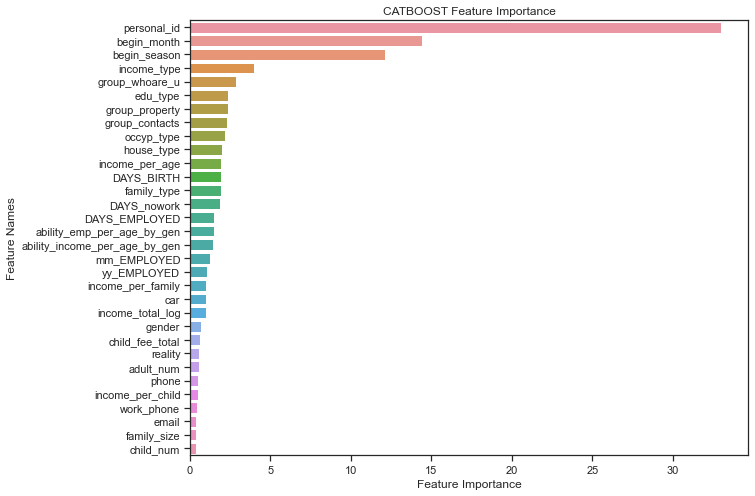

In [407]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [408]:
best_submit = submit.copy()
for i in range(3):
    best_submit[str(i)] = (cat_pred_test)[:,i]

In [409]:
best_submit.set_index('index').apply(np.argmax, axis = 1).value_counts()

2    8057
1    1437
0     506
dtype: int64

In [410]:
best_submit.to_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/preprocessing/catboost_renew_best_submit.csv', index = False)

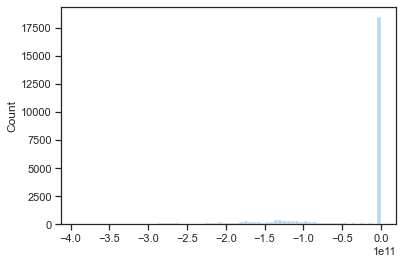

In [419]:
sns.histplot(x = train.income_total_log.apply(np.exp) - train.child_fee_total, data = train[train.child_num > 0])

In [421]:
train.income_total_log.apply(np.exp)

0        202501.0
1        247501.0
2        450001.0
3        202501.0
4        157501.0
           ...   
26446    225001.0
26447    180001.0
26448    292501.0
26449    171001.0
26450     81001.0
Name: income_total_log, Length: 26451, dtype: float64

In [422]:
train.child_fee_total

0        0.000000e+00
1        1.317699e+11
2        0.000000e+00
3        0.000000e+00
4        0.000000e+00
             ...     
26446    2.202007e+11
26447    1.140941e+11
26448    0.000000e+00
26449    0.000000e+00
26450    0.000000e+00
Name: child_fee_total, Length: 26451, dtype: float64

In [350]:
n_fold = 10
seed = 42

def objective(trial):
    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    folds=[]
    for train_idx, valid_idx in skfold.split(X, y):
            folds.append((train_idx, valid_idx))
            
    cat_pred = np.zeros((X.shape[0], n_class))
    cat_pred_test = np.zeros((X_test.shape[0], n_class))
    cat_cols = categorical_feats+ ['gender', 'car', 'reality', 'phone', 'email', 'work_phone']

    param = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 1200, 4000, 400),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 12, 2),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    model_folds = []    
    for fold in range(n_fold):
        print(f'\n----------------- Fold {fold+1} -----------------\n')
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
        valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

        model_cat = CatBoostClassifier(**param)
        model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=200)
        
        model_folds.append(model_cat)
        cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
        cat_pred_test += model_cat.predict_proba(X_test) / n_fold
        print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

    print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')
    logloss = log_loss(y, cat_pred)
    return logloss

In [351]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=6000)

[I 2021-06-17 16:47:55,768] A new study created in memory with name: no-name-13150361-a7d4-4369-a785-4011c721f442
Custom logger is already specified. Specify more than one logger at same time is not thread safe.


----------------- Fold 1 -----------------

0:	learn: 1.0719750	test: 1.0715284	best: 1.0715284 (0)	total: 11.4ms	remaining: 31.9s
200:	learn: 0.7667121	test: 0.7346153	best: 0.7346145 (198)	total: 954ms	remaining: 12.3s
400:	learn: 0.7377638	test: 0.6985819	best: 0.6985478 (396)	total: 1.9s	remaining: 11.4s
600:	learn: 0.7252071	test: 0.6825963	best: 0.6825962 (599)	total: 2.82s	remaining: 10.3s
800:	learn: 0.7171678	test: 0.6731787	best: 0.6731787 (800)	total: 3.8s	remaining: 9.48s
1000:	learn: 0.7124924	test: 0.6690663	best: 0.6690594 (994)	total: 4.75s	remaining: 8.54s
1200:	learn: 0.7076381	test: 0.6644963	best: 0.6644941 (1198)	total: 5.71s	remaining: 7.6s
1400:	learn: 0.7036144	test: 0.6618116	best: 0.6618116 (1397)	total: 6.75s	remaining: 6.74s
1600:	learn: 0.6999179	test: 0.6600589	best: 0.6600589 (1598)	total: 7.86s	remaining: 5.89s
1800:	learn: 0.6969317	test: 0.6595488	best: 0.6595478 (1797)	total: 8.9s	remaining: 4.94s
2000:	learn: 0.6942792	test: 0.6583610	best: 0.658361

0:	learn: 1.0783979	test: 1.0784207	best: 1.0784207 (0)	total: 7.61ms	remaining: 21.3s
200:	learn: 0.7637600	test: 0.7396104	best: 0.7396104 (200)	total: 1s	remaining: 12.9s
400:	learn: 0.7333698	test: 0.6981468	best: 0.6981378 (398)	total: 2s	remaining: 12s
600:	learn: 0.7215694	test: 0.6842578	best: 0.6842361 (582)	total: 2.96s	remaining: 10.8s
800:	learn: 0.7152020	test: 0.6778552	best: 0.6778552 (799)	total: 3.94s	remaining: 9.84s
1000:	learn: 0.7112722	test: 0.6757449	best: 0.6757209 (986)	total: 4.91s	remaining: 8.82s
1200:	learn: 0.7071899	test: 0.6731985	best: 0.6731741 (1199)	total: 5.87s	remaining: 7.82s
1400:	learn: 0.7031685	test: 0.6707910	best: 0.6707910 (1400)	total: 6.9s	remaining: 6.89s
1600:	learn: 0.7000622	test: 0.6696508	best: 0.6696200 (1582)	total: 7.9s	remaining: 5.92s
1800:	learn: 0.6968545	test: 0.6690527	best: 0.6690021 (1792)	total: 8.86s	remaining: 4.92s
2000:	learn: 0.6943392	test: 0.6685474	best: 0.6684875 (1990)	total: 9.82s	remaining: 3.92s
2200:	learn:

[I 2021-06-17 16:50:01,724] Trial 0 finished with value: 0.6693180374883876 and parameters: {'learning_rate': 0.04635497725342579, 'n_estimators': 2800, 'colsample_bylevel': 0.028446117328767603, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6693180374883876.



----------------- Fold 1 -----------------

0:	learn: 1.0859775	test: 1.0857679	best: 1.0857679 (0)	total: 8.02ms	remaining: 12.8s
200:	learn: 0.8207324	test: 0.8077732	best: 0.8077732 (200)	total: 854ms	remaining: 5.94s
400:	learn: 0.7865180	test: 0.7615739	best: 0.7615739 (400)	total: 1.74s	remaining: 5.21s
600:	learn: 0.7631501	test: 0.7296194	best: 0.7296193 (599)	total: 2.68s	remaining: 4.45s
800:	learn: 0.7501360	test: 0.7123956	best: 0.7123956 (800)	total: 3.67s	remaining: 3.66s
1000:	learn: 0.7394111	test: 0.6975823	best: 0.6975822 (997)	total: 4.61s	remaining: 2.76s
1200:	learn: 0.7323161	test: 0.6885622	best: 0.6885621 (1198)	total: 5.57s	remaining: 1.85s
1400:	learn: 0.7276622	test: 0.6823873	best: 0.6823872 (1397)	total: 6.54s	remaining: 929ms
1599:	learn: 0.7233959	test: 0.6777822	best: 0.6777821 (1597)	total: 7.52s	remaining: 0us

bestTest = 0.6777821049
bestIteration = 1597

Shrink model to first 1598 iterations.
CV Log Loss Score: 0.677782

----------------- Fold 2 ---

1000:	learn: 0.7365041	test: 0.7090624	best: 0.7090624 (1000)	total: 4.67s	remaining: 2.79s
1200:	learn: 0.7304861	test: 0.7012787	best: 0.7012759 (1195)	total: 5.55s	remaining: 1.84s
1400:	learn: 0.7260086	test: 0.6953742	best: 0.6953742 (1400)	total: 6.4s	remaining: 909ms
1599:	learn: 0.7203581	test: 0.6882672	best: 0.6882672 (1599)	total: 7.38s	remaining: 0us

bestTest = 0.6882672326
bestIteration = 1599

CV Log Loss Score: 0.688267

----------------- Fold 10 -----------------

0:	learn: 1.0890260	test: 1.0890236	best: 1.0890236 (0)	total: 7.58ms	remaining: 12.1s
200:	learn: 0.8276835	test: 0.8175924	best: 0.8175924 (200)	total: 895ms	remaining: 6.23s
400:	learn: 0.7925783	test: 0.7753460	best: 0.7753339 (393)	total: 1.74s	remaining: 5.2s
600:	learn: 0.7655465	test: 0.7424198	best: 0.7424198 (599)	total: 2.63s	remaining: 4.37s
800:	learn: 0.7462535	test: 0.7188462	best: 0.7188436 (798)	total: 3.61s	remaining: 3.6s
1000:	learn: 0.7358913	test: 0.7066068	best: 0.7066068 (999)	total: 4

[I 2021-06-17 16:51:21,713] Trial 1 finished with value: 0.688836749032952 and parameters: {'learning_rate': 0.021711359443392465, 'n_estimators': 1600, 'colsample_bylevel': 0.026439583708441586, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6229306906254795}. Best is trial 0 with value: 0.6693180374883876.



----------------- Fold 1 -----------------

0:	learn: 1.0902771	test: 1.0902865	best: 1.0902865 (0)	total: 16.9ms	remaining: 1m 7s
200:	learn: 0.7590139	test: 0.7233567	best: 0.7233567 (200)	total: 5.46s	remaining: 1m 43s
400:	learn: 0.7299497	test: 0.6812588	best: 0.6812577 (398)	total: 10.7s	remaining: 1m 36s
600:	learn: 0.7193760	test: 0.6672243	best: 0.6672243 (600)	total: 16.6s	remaining: 1m 33s
800:	learn: 0.7110620	test: 0.6614379	best: 0.6614379 (800)	total: 24s	remaining: 1m 36s
1000:	learn: 0.7050628	test: 0.6596081	best: 0.6595910 (995)	total: 31.6s	remaining: 1m 34s
1200:	learn: 0.6994671	test: 0.6588554	best: 0.6588554 (1200)	total: 38.9s	remaining: 1m 30s
1400:	learn: 0.6943318	test: 0.6584950	best: 0.6584945 (1399)	total: 46.5s	remaining: 1m 26s
1600:	learn: 0.6891511	test: 0.6581319	best: 0.6581221 (1598)	total: 54.2s	remaining: 1m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6581069762
bestIteration = 1651

Shrink model to first 1652 iterat

1400:	learn: 0.6928081	test: 0.6737348	best: 0.6737112 (1377)	total: 48.6s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6736552089
bestIteration = 1432

Shrink model to first 1433 iterations.
CV Log Loss Score: 0.673655

----------------- Fold 9 -----------------

0:	learn: 1.0902644	test: 1.0902996	best: 1.0902996 (0)	total: 21.4ms	remaining: 1m 25s
200:	learn: 0.7705645	test: 0.7535918	best: 0.7535918 (200)	total: 5.16s	remaining: 1m 37s
400:	learn: 0.7292976	test: 0.6949743	best: 0.6949743 (400)	total: 10.8s	remaining: 1m 36s
600:	learn: 0.7192537	test: 0.6806237	best: 0.6806237 (599)	total: 16.3s	remaining: 1m 32s
800:	learn: 0.7107975	test: 0.6736113	best: 0.6736113 (800)	total: 24.2s	remaining: 1m 36s
1000:	learn: 0.7050496	test: 0.6712126	best: 0.6712126 (1000)	total: 32s	remaining: 1m 35s
1200:	learn: 0.6995678	test: 0.6702880	best: 0.6702695 (1199)	total: 39.8s	remaining: 1m 32s
1400:	learn: 0.6938760	test: 0.6692641	best: 0.6692501 (1

[I 2021-06-17 17:02:11,113] Trial 2 finished with value: 0.6676516012424974 and parameters: {'learning_rate': 0.018845800568165955, 'n_estimators': 4000, 'colsample_bylevel': 0.06138249106981117, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5833610870926725}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0626585	test: 1.0627002	best: 1.0627002 (0)	total: 3.48ms	remaining: 9.74s
200:	learn: 0.8094793	test: 0.7890382	best: 0.7890381 (199)	total: 675ms	remaining: 8.73s
400:	learn: 0.7749520	test: 0.7437819	best: 0.7437769 (399)	total: 1.37s	remaining: 8.17s
600:	learn: 0.7588390	test: 0.7225128	best: 0.7225092 (590)	total: 2.08s	remaining: 7.63s
800:	learn: 0.7455195	test: 0.7023907	best: 0.7023473 (789)	total: 2.77s	remaining: 6.91s
1000:	learn: 0.7424257	test: 0.6983657	best: 0.6983553 (999)	total: 3.41s	remaining: 6.13s
1200:	learn: 0.7392649	test: 0.6946307	best: 0.6946226 (1198)	total: 4.09s	remaining: 5.45s
1400:	learn: 0.7339386	test: 0.6874294	best: 0.6874294 (1400)	total: 4.78s	remaining: 4.78s
1600:	learn: 0.7309874	test: 0.6842126	best: 0.6842121 (1597)	total: 5.46s	remaining: 4.09s
1800:	learn: 0.7285299	test: 0.6812187	best: 0.6811899 (1787)	total: 6.21s	remaining: 3.45s
2000:	learn: 0.7269096	test: 0.6791526	best: 0.67

1400:	learn: 0.7350307	test: 0.7135239	best: 0.7135239 (1400)	total: 5.57s	remaining: 5.56s
1600:	learn: 0.7309383	test: 0.7083166	best: 0.7083163 (1593)	total: 6.31s	remaining: 4.73s
1800:	learn: 0.7278079	test: 0.7049556	best: 0.7049555 (1797)	total: 7.18s	remaining: 3.98s
2000:	learn: 0.7261562	test: 0.7030436	best: 0.7030217 (1983)	total: 7.97s	remaining: 3.18s
2200:	learn: 0.7243793	test: 0.7013098	best: 0.7012574 (2153)	total: 8.77s	remaining: 2.39s
2400:	learn: 0.7229088	test: 0.7003920	best: 0.7003739 (2372)	total: 9.58s	remaining: 1.59s
2600:	learn: 0.7212499	test: 0.6980324	best: 0.6979942 (2517)	total: 10.4s	remaining: 797ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6979942369
bestIteration = 2517

Shrink model to first 2518 iterations.
CV Log Loss Score: 0.697994

----------------- Fold 7 -----------------

0:	learn: 1.0626658	test: 1.0626693	best: 1.0626693 (0)	total: 4.32ms	remaining: 12.1s
200:	learn: 0.8113804	test: 0.8041874	best: 0.8041874 (

[I 2021-06-17 17:03:53,282] Trial 3 finished with value: 0.685157067019145 and parameters: {'learning_rate': 0.08409498077899194, 'n_estimators': 2800, 'colsample_bylevel': 0.011152083237916863, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.208776545693003}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0503357	test: 1.0493987	best: 1.0493987 (0)	total: 31.5ms	remaining: 1m 40s
200:	learn: 0.6751230	test: 0.6598191	best: 0.6596480 (195)	total: 4.11s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.659071243
bestIteration = 281

Shrink model to first 282 iterations.
CV Log Loss Score: 0.659071

----------------- Fold 2 -----------------

0:	learn: 1.0617892	test: 1.0617972	best: 1.0617972 (0)	total: 7.87ms	remaining: 25.2s
200:	learn: 0.6769069	test: 0.6588182	best: 0.6588182 (200)	total: 4.01s	remaining: 59.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6579751237
bestIteration = 216

Shrink model to first 217 iterations.
CV Log Loss Score: 0.657975

----------------- Fold 3 -----------------

0:	learn: 1.0617860	test: 1.0618001	best: 1.0618001 (0)	total: 7.73ms	remaining: 24.7s
200:	learn: 0.6788005	test: 0.6647181	best: 0.6647181 (200)	total: 3.76s	remaining: 56.2s


[I 2021-06-17 17:05:19,495] Trial 4 finished with value: 0.6694335860492017 and parameters: {'learning_rate': 0.0862607106939922, 'n_estimators': 3200, 'colsample_bylevel': 0.09943932782671508, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5799013811719267}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0644403	test: 1.0644798	best: 1.0644798 (0)	total: 15.4ms	remaining: 18.4s
200:	learn: 0.8026282	test: 0.7822718	best: 0.7822603 (193)	total: 3.3s	remaining: 16.4s
400:	learn: 0.7584133	test: 0.7250464	best: 0.7250464 (400)	total: 6.8s	remaining: 13.5s
600:	learn: 0.7380169	test: 0.6962386	best: 0.6962351 (595)	total: 10.3s	remaining: 10.3s
800:	learn: 0.7265969	test: 0.6813166	best: 0.6812459 (799)	total: 13.9s	remaining: 6.92s
1000:	learn: 0.7207453	test: 0.6755421	best: 0.6754648 (978)	total: 17.4s	remaining: 3.45s
1199:	learn: 0.7160265	test: 0.6715756	best: 0.6715582 (1191)	total: 21.1s	remaining: 0us

bestTest = 0.6715581871
bestIteration = 1191

Shrink model to first 1192 iterations.
CV Log Loss Score: 0.671558

----------------- Fold 2 -----------------

0:	learn: 1.0644302	test: 1.0645276	best: 1.0645276 (0)	total: 16ms	remaining: 19.2s
200:	learn: 0.7852833	test: 0.7681132	best: 0.7681130 (198)	total: 3.27s	remaining: 1

[I 2021-06-17 17:09:01,461] Trial 5 finished with value: 0.6771563232617144 and parameters: {'learning_rate': 0.07974271617342324, 'n_estimators': 1200, 'colsample_bylevel': 0.019786064624049304, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3052393426579132}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0602466	test: 1.0595974	best: 1.0595974 (0)	total: 19.5ms	remaining: 1m 10s
200:	learn: 0.7543226	test: 0.7181530	best: 0.7181530 (200)	total: 4.34s	remaining: 1m 13s
400:	learn: 0.7301984	test: 0.6855305	best: 0.6855299 (396)	total: 8.82s	remaining: 1m 10s
600:	learn: 0.7200878	test: 0.6740504	best: 0.6740282 (597)	total: 12.9s	remaining: 1m 4s
800:	learn: 0.7153905	test: 0.6697147	best: 0.6696631 (790)	total: 17.7s	remaining: 1m 1s
1000:	learn: 0.7124041	test: 0.6670455	best: 0.6670346 (997)	total: 22.4s	remaining: 58.3s
1200:	learn: 0.7090208	test: 0.6646913	best: 0.6646912 (1196)	total: 27s	remaining: 53.9s
1400:	learn: 0.7061540	test: 0.6639508	best: 0.6639345 (1394)	total: 31.1s	remaining: 48.8s
1600:	learn: 0.7033772	test: 0.6633491	best: 0.6632659 (1558)	total: 35.2s	remaining: 43.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6632658839
bestIteration = 1558

Shrink model to first 1559 iterations.

CV Log Loss Score: 0.667725

----------------- Fold 8 -----------------

0:	learn: 1.0695037	test: 1.0694904	best: 1.0694904 (0)	total: 18.6ms	remaining: 1m 6s
200:	learn: 0.7736452	test: 0.7551782	best: 0.7551780 (194)	total: 3.73s	remaining: 1m 3s
400:	learn: 0.7327290	test: 0.7050518	best: 0.7050518 (398)	total: 8.97s	remaining: 1m 11s
600:	learn: 0.7234681	test: 0.6931658	best: 0.6931590 (599)	total: 13.5s	remaining: 1m 7s
800:	learn: 0.7153887	test: 0.6844896	best: 0.6844665 (799)	total: 18.3s	remaining: 1m 3s
1000:	learn: 0.7120070	test: 0.6826172	best: 0.6826030 (994)	total: 22.7s	remaining: 59s
1200:	learn: 0.7090353	test: 0.6803957	best: 0.6803812 (1181)	total: 26.8s	remaining: 53.6s
1400:	learn: 0.7050622	test: 0.6784500	best: 0.6784500 (1400)	total: 33.7s	remaining: 52.9s
1600:	learn: 0.7013740	test: 0.6775920	best: 0.6775357 (1588)	total: 38.6s	remaining: 48.2s
1800:	learn: 0.6983195	test: 0.6769825	best: 0.6767932 (1755)	total: 43.3s	remaining: 43.2s
2000:	learn: 0.6951715

[I 2021-06-17 17:17:05,112] Trial 6 finished with value: 0.6716959798218833 and parameters: {'learning_rate': 0.06750702000488477, 'n_estimators': 3600, 'colsample_bylevel': 0.022977400541708173, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.409209197355975}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0847751	test: 1.0847907	best: 1.0847907 (0)	total: 20ms	remaining: 40.1s
200:	learn: 0.7310964	test: 0.6817893	best: 0.6817893 (200)	total: 7.57s	remaining: 1m 7s
400:	learn: 0.7126887	test: 0.6599589	best: 0.6599589 (400)	total: 16s	remaining: 1m 3s
600:	learn: 0.7011824	test: 0.6570748	best: 0.6570748 (600)	total: 27.6s	remaining: 1m 4s
800:	learn: 0.6900215	test: 0.6559083	best: 0.6558794 (786)	total: 39.3s	remaining: 58.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6555997446
bestIteration = 865

Shrink model to first 866 iterations.
CV Log Loss Score: 0.655600

----------------- Fold 2 -----------------

0:	learn: 1.0804012	test: 1.0805443	best: 1.0805443 (0)	total: 52.9ms	remaining: 1m 45s
200:	learn: 0.7293687	test: 0.6773829	best: 0.6773829 (200)	total: 7.24s	remaining: 1m 4s
400:	learn: 0.7143858	test: 0.6579830	best: 0.6579711 (399)	total: 15s	remaining: 59.6s
600:	learn: 0.7029575	test: 0.6551

[I 2021-06-17 17:25:58,431] Trial 7 finished with value: 0.6666297448976278 and parameters: {'learning_rate': 0.03148804286737452, 'n_estimators': 2000, 'colsample_bylevel': 0.08550203288540487, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7777311966683135}. Best is trial 7 with value: 0.6666297448976278.



----------------- Fold 1 -----------------

0:	learn: 1.0767257	test: 1.0767506	best: 1.0767506 (0)	total: 15ms	remaining: 54.1s
200:	learn: 0.7203198	test: 0.6673557	best: 0.6673535 (199)	total: 7.54s	remaining: 2m 7s
400:	learn: 0.6996682	test: 0.6588026	best: 0.6587897 (399)	total: 17.8s	remaining: 2m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6579493263
bestIteration = 460

Shrink model to first 461 iterations.
CV Log Loss Score: 0.657949

----------------- Fold 2 -----------------

0:	learn: 1.0698041	test: 1.0700329	best: 1.0700329 (0)	total: 60.8ms	remaining: 3m 38s
200:	learn: 0.7202589	test: 0.6650453	best: 0.6650453 (200)	total: 7.14s	remaining: 2m
400:	learn: 0.6994214	test: 0.6571617	best: 0.6571352 (399)	total: 17.6s	remaining: 2m 20s
600:	learn: 0.6824713	test: 0.6565818	best: 0.6565818 (600)	total: 28.8s	remaining: 2m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6565817977
bestIteration = 600

Shrink model to fir

[I 2021-06-17 17:31:45,675] Trial 8 finished with value: 0.6684161101145222 and parameters: {'learning_rate': 0.050290469207485894, 'n_estimators': 3600, 'colsample_bylevel': 0.0844832461445846, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.46409744364223526}. Best is trial 7 with value: 0.6666297448976278.



----------------- Fold 1 -----------------

0:	learn: 1.0902973	test: 1.0903066	best: 1.0903066 (0)	total: 4.03ms	remaining: 14.5s
200:	learn: 0.7603849	test: 0.7274805	best: 0.7274805 (200)	total: 1.97s	remaining: 33.3s
400:	learn: 0.7275197	test: 0.6875233	best: 0.6875233 (399)	total: 4.17s	remaining: 33.3s
600:	learn: 0.7099885	test: 0.6729364	best: 0.6729364 (600)	total: 6.61s	remaining: 33s
800:	learn: 0.6947885	test: 0.6667431	best: 0.6667431 (800)	total: 9.18s	remaining: 32.1s
1000:	learn: 0.6835457	test: 0.6638972	best: 0.6638972 (1000)	total: 11.5s	remaining: 29.7s
1200:	learn: 0.6719056	test: 0.6625263	best: 0.6625263 (1200)	total: 13.9s	remaining: 27.7s
1400:	learn: 0.6616091	test: 0.6615561	best: 0.6614426 (1373)	total: 16.3s	remaining: 25.5s
1600:	learn: 0.6510686	test: 0.6612267	best: 0.6611365 (1584)	total: 18.7s	remaining: 23.4s
1800:	learn: 0.6414221	test: 0.6609736	best: 0.6608808 (1743)	total: 21.3s	remaining: 21.3s
2000:	learn: 0.6311318	test: 0.6606162	best: 0.660

0:	learn: 1.0902783	test: 1.0902973	best: 1.0902973 (0)	total: 8.47ms	remaining: 30.5s
200:	learn: 0.7669556	test: 0.7502236	best: 0.7502236 (200)	total: 2.04s	remaining: 34.6s
400:	learn: 0.7309025	test: 0.7078239	best: 0.7078239 (399)	total: 4.16s	remaining: 33.2s
600:	learn: 0.7095422	test: 0.6895300	best: 0.6895300 (600)	total: 6.7s	remaining: 33.4s
800:	learn: 0.6935370	test: 0.6830215	best: 0.6830215 (800)	total: 9.42s	remaining: 32.9s
1000:	learn: 0.6801295	test: 0.6801575	best: 0.6801575 (1000)	total: 12.1s	remaining: 31.4s
1200:	learn: 0.6685944	test: 0.6786046	best: 0.6786046 (1200)	total: 14.4s	remaining: 28.9s
1400:	learn: 0.6568918	test: 0.6776909	best: 0.6776909 (1400)	total: 16.9s	remaining: 26.5s
1600:	learn: 0.6453588	test: 0.6770653	best: 0.6770460 (1598)	total: 19.4s	remaining: 24.2s
1800:	learn: 0.6350211	test: 0.6763091	best: 0.6762586 (1789)	total: 21.9s	remaining: 21.9s
2000:	learn: 0.6261493	test: 0.6758481	best: 0.6757802 (1964)	total: 24.2s	remaining: 19.3s
St

[I 2021-06-17 17:35:52,666] Trial 9 finished with value: 0.6713441740930074 and parameters: {'learning_rate': 0.01879975474282336, 'n_estimators': 3600, 'colsample_bylevel': 0.058799289840164824, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1150875401585643}. Best is trial 7 with value: 0.6666297448976278.



----------------- Fold 1 -----------------

0:	learn: 1.0759904	test: 1.0745908	best: 1.0745908 (0)	total: 31.6ms	remaining: 1m 3s
200:	learn: 0.7152116	test: 0.6686046	best: 0.6686046 (200)	total: 41.1s	remaining: 6m 8s
400:	learn: 0.6856332	test: 0.6630142	best: 0.6630142 (400)	total: 1m 49s	remaining: 7m 14s
600:	learn: 0.6389885	test: 0.6614979	best: 0.6614769 (599)	total: 3m 43s	remaining: 8m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6612741983
bestIteration = 613

Shrink model to first 614 iterations.
CV Log Loss Score: 0.661274

----------------- Fold 2 -----------------

0:	learn: 1.0808764	test: 1.0809218	best: 1.0809218 (0)	total: 19.4ms	remaining: 38.8s
200:	learn: 0.7171579	test: 0.6695147	best: 0.6695136 (198)	total: 35.9s	remaining: 5m 21s
400:	learn: 0.6796839	test: 0.6614321	best: 0.6614321 (400)	total: 1m 52s	remaining: 7m 28s
600:	learn: 0.6339218	test: 0.6591292	best: 0.6590371 (587)	total: 3m 44s	remaining: 8m 42s
Stopped by overfitti

[I 2021-06-17 18:20:25,659] Trial 10 finished with value: 0.6705858303823019 and parameters: {'learning_rate': 0.040529377556869105, 'n_estimators': 2000, 'colsample_bylevel': 0.08335704164788042, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6666297448976278.



----------------- Fold 1 -----------------

0:	learn: 1.0936863	test: 1.0936918	best: 1.0936918 (0)	total: 19ms	remaining: 38.1s
200:	learn: 0.8011006	test: 0.7823063	best: 0.7823063 (200)	total: 7.82s	remaining: 1m 10s
400:	learn: 0.7582655	test: 0.7226973	best: 0.7226973 (400)	total: 14.7s	remaining: 58.6s
600:	learn: 0.7375857	test: 0.6930581	best: 0.6930581 (600)	total: 22.4s	remaining: 52.2s
800:	learn: 0.7256405	test: 0.6756428	best: 0.6756427 (798)	total: 32.3s	remaining: 48.3s
1000:	learn: 0.7198121	test: 0.6679512	best: 0.6679512 (1000)	total: 40.7s	remaining: 40.6s
1200:	learn: 0.7148531	test: 0.6628682	best: 0.6628682 (1200)	total: 52.4s	remaining: 34.9s
1400:	learn: 0.7099760	test: 0.6602557	best: 0.6602557 (1400)	total: 1m 10s	remaining: 29.9s
1600:	learn: 0.7060579	test: 0.6589713	best: 0.6589713 (1600)	total: 1m 26s	remaining: 21.5s
1800:	learn: 0.7026776	test: 0.6583699	best: 0.6583666 (1799)	total: 1m 42s	remaining: 11.3s
1999:	learn: 0.6987245	test: 0.6575042	best: 0

600:	learn: 0.7364886	test: 0.7077112	best: 0.7077112 (600)	total: 22.6s	remaining: 52.7s
800:	learn: 0.7238688	test: 0.6906513	best: 0.6906513 (800)	total: 32s	remaining: 47.9s
1000:	learn: 0.7177543	test: 0.6830158	best: 0.6830158 (1000)	total: 40.1s	remaining: 40.1s
1200:	learn: 0.7128119	test: 0.6784535	best: 0.6784535 (1200)	total: 52s	remaining: 34.6s
1400:	learn: 0.7078601	test: 0.6757963	best: 0.6757963 (1400)	total: 1m 10s	remaining: 30s
1600:	learn: 0.7039733	test: 0.6746721	best: 0.6746615 (1597)	total: 1m 27s	remaining: 21.8s
1800:	learn: 0.7004163	test: 0.6740242	best: 0.6740202 (1799)	total: 1m 43s	remaining: 11.5s
1999:	learn: 0.6963246	test: 0.6734948	best: 0.6734948 (1999)	total: 2m 3s	remaining: 0us

bestTest = 0.67349485
bestIteration = 1999

CV Log Loss Score: 0.673495

----------------- Fold 9 -----------------

0:	learn: 1.0936788	test: 1.0936995	best: 1.0936995 (0)	total: 21.9ms	remaining: 43.8s
200:	learn: 0.8034222	test: 0.7912412	best: 0.7912412 (200)	total: 6

[I 2021-06-17 18:40:42,294] Trial 11 finished with value: 0.6679547464488006 and parameters: {'learning_rate': 0.011094214686002694, 'n_estimators': 2000, 'colsample_bylevel': 0.05634563465934163, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9189877277551838}. Best is trial 7 with value: 0.6666297448976278.


In [352]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 12
Best trial:
  Value: 0.6666297448976278
  Params: 
    learning_rate: 0.03148804286737452
    n_estimators: 2000
    colsample_bylevel: 0.08550203288540487
    depth: 8
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.7777311966683135


In [353]:
trial.params

{'learning_rate': 0.03148804286737452,
 'n_estimators': 2000,
 'colsample_bylevel': 0.08550203288540487,
 'depth': 8,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.7777311966683135}

In [355]:
skfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=55)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats
print('category features : {}'.format(cat_cols))
model_folds = [] 
# 15Fold-CV (StratifiedKFold)
for fold in range(len(folds)):
    print(f'\n----------------- Fold {fold+1} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(**trial.params)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)
    model_folds.append(model_cat)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / len(folds)
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

category features : ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'group_property', 'group_contacts', 'group_whoare_u']

----------------- Fold 1 -----------------

0:	learn: 1.0806170	test: 1.0806682	best: 1.0806682 (0)	total: 57.7ms	remaining: 1m 55s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

100:	learn: 0.7627445	test: 0.7495138	best: 0.7495138 (100)	total: 2.79s	remaining: 52.4s
200:	learn: 0.7254274	test: 0.6962753	best: 0.6962753 (200)	total: 6.02s	remaining: 53.9s
300:	learn: 0.7162122	test: 0.6825340	best: 0.6825340 (300)	total: 9.41s	remaining: 53.1s
400:	learn: 0.7101788	test: 0.6758263	best: 0.6758263 (400)	total: 13.1s	remaining: 52.4s
500:	learn: 0.7044683	test: 0.6735712	best: 0.6735051 (492)	total: 18.2s	remaining: 54.4s
600:	learn: 0.6997974	test: 0.6723796	best: 0.6723796 (600)	total: 23.1s	remaining: 53.8s
700:	learn: 0.6948198	test: 0.6713737	best: 0.6713737 (700)	total: 28.1s	remaining: 52s
800:	learn: 0.6897517	test: 0.6709966	best: 0.6709358 (799)	total: 33.3s	remaining: 49.9s
900:	learn: 0.6850216	test: 0.6702976	best: 0.6702422 (875)	total: 38.3s	remaining: 46.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6702422071
bestIteration = 875

Shrink model to first 876 iterations.
CV Log Loss Score: 0.670242

----------------- Fold 2 

0:	learn: 1.0847499	test: 1.0846703	best: 1.0846703 (0)	total: 22.3ms	remaining: 44.5s
100:	learn: 0.7576027	test: 0.7352514	best: 0.7352514 (100)	total: 3.33s	remaining: 1m 2s
200:	learn: 0.7272483	test: 0.6915637	best: 0.6915637 (200)	total: 6.41s	remaining: 57.3s
300:	learn: 0.7173648	test: 0.6759434	best: 0.6759434 (300)	total: 9.88s	remaining: 55.8s
400:	learn: 0.7107114	test: 0.6695557	best: 0.6695557 (400)	total: 14s	remaining: 55.7s
500:	learn: 0.7047929	test: 0.6671332	best: 0.6671332 (500)	total: 19.1s	remaining: 57.2s
600:	learn: 0.6990090	test: 0.6654321	best: 0.6653637 (584)	total: 24.4s	remaining: 56.9s
700:	learn: 0.6930584	test: 0.6643307	best: 0.6643307 (700)	total: 29.6s	remaining: 54.9s
800:	learn: 0.6881252	test: 0.6632413	best: 0.6632351 (797)	total: 34.8s	remaining: 52.1s
900:	learn: 0.6829231	test: 0.6627751	best: 0.6627706 (899)	total: 39.6s	remaining: 48.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6626651358
bestIteration = 927

Shrin

In [378]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(12, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('CATBOOST Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

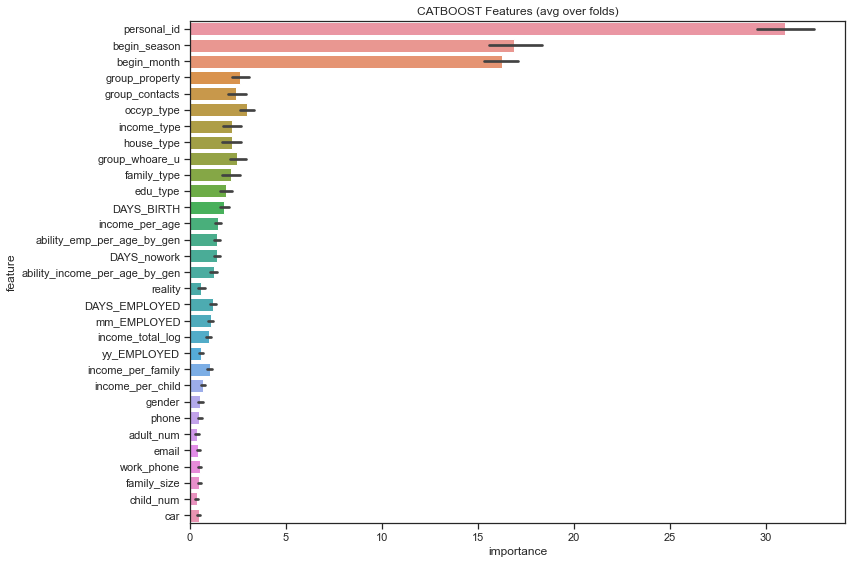

In [379]:
feats = X.columns
feature_importance_df = pd.DataFrame()
n = len(model_folds)
for i in range(n):
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = model_folds[i].feature_importances_
    fold_importance_df["fold"] = i
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
display_importances(feature_importance_df)

In [356]:
for i in range(3):
    submit[str(i)] = (cat_pred_test)[:,i]

In [357]:
submit.set_index('index').apply(np.argmax, axis = 1).value_counts()

2    8099
1    1417
0     484
dtype: int64

In [358]:
submit.to_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/preprocessing/catboost_renew+optuna.csv', index = False)